In [94]:
import os
print(os.getcwd())

C:\Users\xps\Desktop\MLProjects\ML\6.T.S. Forecasting


In [95]:
import tensorflow as tf
import sklearn as skl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)
print(skl.__version__)
print(pd.__version__)
print(np.__version__)
#print(plt.__version__)

2.17.0
1.5.1
2.2.2
1.26.4


**Key Questions to Address:**
1. What is **Random Forest/Gradient Boosting Trees**?
2. How is it utilized?
3. Why is it significant?
4. What is the corresponding mathematical formula?
5. How can it be implemented in Python?

---
**a. Random Forest/Gradient Boosting Trees**
- **Use Case:** Effective for multivariate time series data.
- **Advantages:**
    - Can capture non-linearities and complex interactions between variables.
    - Handles missing values well.
- **Limitations:** Requires feature engineering (e.g., lag features) and doesn't naturally capture temporal dependencies.
---
**b. XGBoost/CatBoost/LightGBM**
- **Use Case:** Popular for structured, multivariate time series data.
- **Advantages:**
    - Can model complex relationships and non-linear dependencies.
    - Can handle irregular time intervals.
- **Limitations:** Requires careful feature engineering (lags, rolling windows).
---
**c. Support Vector Regression (SVR)**
- **Use Case:** Suitable for small to medium-sized datasets.
- **Advantages:**
    - Works well for non-linear trends.
- **Limitations:** Doesn't scale well with large datasets.

# 1. Random Forest

**Time Series Forecasting with Random Forest**
- While Random Forest is commonly used for classification and regression tasks, it can also be adapted for time series forecasting.
- However, **it does not naturally handle sequential data, so you need to convert the time series problem into a supervised learning task by creating lag features (using past values to predict future ones)**.
---
### Steps for Time Series Forecasting with Random Forest
---
**1. Transform the Time Series into a Supervised Problem**
- Since Random Forest models are designed for supervised learning, **we must convert the time series data into a supervised learning problem by creating lagged features** (i.e., past values to predict future values).

   **For example**, to predict the value at time $t$, you might use the values at times $t-1, t-2, \cdots, t-n$.
---
**2. Create Features from Lagged Observations**
- To create lag features, you can shift the original time series data by several time steps and create a new dataset where each row represents the lagged values.
---
**3. Train a Random Forest Model**
- Once you have transformed the time series into a supervised learning dataset, you can split the data into training and testing sets.
- Then, train the Random Forest Regressor on the training data and evaluate its performance on the test data.
---
**4. Forecast Future Values**
- Using the trained Random Forest model, you can forecast future values.
- You can predict one step ahead or multiple steps ahead by iteratively feeding the predicted value back into the model as input for subsequent predictions.

In [96]:
# Step 1: Importing packages
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as pl

In [97]:
# Step 2: Importing ther dataset
ts = pd.read_csv("energy_consumption_2_years.csv", index_col='Date', parse_dates=True)
ts = ts.dropna() # drop the missing values
print("The shape of the T.S. id: ", ts.shape) # shape of the T.S.
print("\n")
ts.info()

The shape of the T.S. id:  (730, 1)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2023-01-01 to 2024-12-30
Data columns (total 1 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Energy Consumption (kWh)  730 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


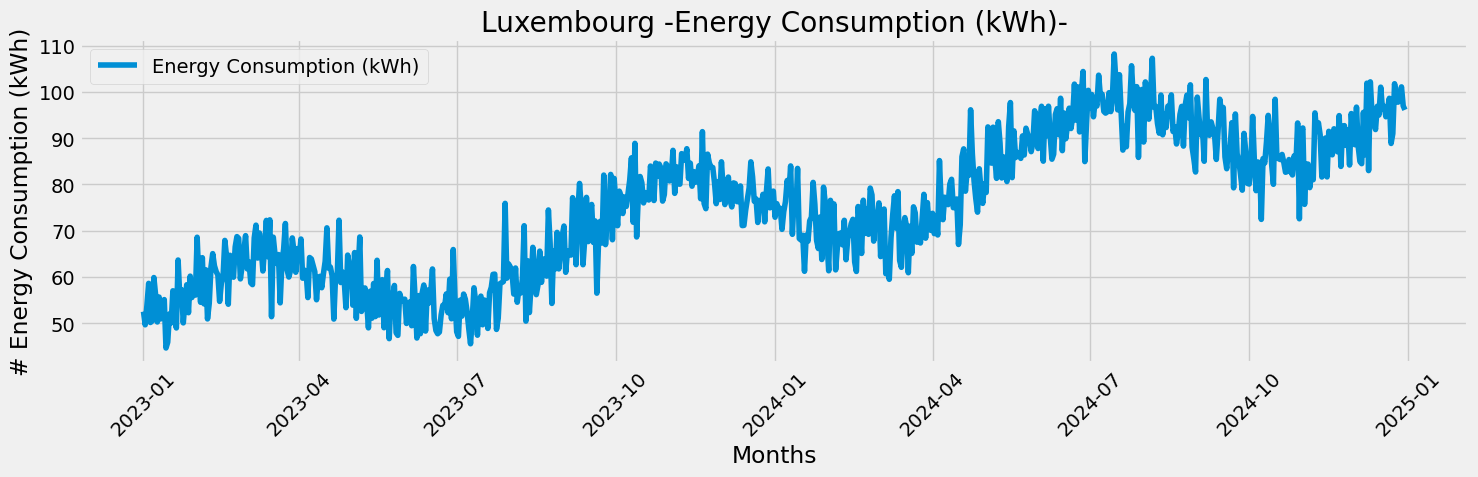

In [98]:
# Plot the time series: date vs. energy consumption
plt.figure(figsize=(15,5))
plt.plot(ts.index, ts['Energy Consumption (kWh)'], label='Energy Consumption (kWh)')

# Adding titles and labels
plt.title("Luxembourg -Energy Consumption (kWh)-")
plt.xlabel("Months")
plt.ylabel("# Energy Consumption (kWh)")
plt.legend()
# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.show()

In [99]:
# Step 3: Create Lag Features
# We create lag features to convert the time series into a supervised learning problem. 
# Here, we use the last 7 time steps to predict the next value.
def create_lag_features(ts, lag=7):  # lag=7 means lag1 = t-1, lag2 = t-2, ..., lag7 = t-7
    ts_lag = ts.copy()  # Create a copy of the original time series
    for i in range(1, lag + 1):  # Loop to create lag features from 1 to lag
        ts_lag[f'lag_{i}'] = ts['Energy Consumption (kWh)'].shift(i)  # Create new columns for each lag
    ts_lag.dropna(inplace=True)  # Drop rows with NaN values caused by the lag
    return ts_lag  # Return the new dataset with lagged features

# Create a dataset with lag features using lag=7
lag = 7  # You can change the lag value to another number as needed
ts_lag = create_lag_features(ts, lag=lag)

# Display the first few rows
print(ts_lag.head())

            Energy Consumption (kWh)      lag_1      lag_2      lag_3  \
Date                                                                    
2023-01-08                 56.117388  59.852775  50.461489  50.136008   
2023-01-09                 50.255143  56.117388  59.852775  50.461489   
2023-01-10                 55.636243  50.255143  56.117388  59.852775   
2023-01-11                 50.925740  55.636243  50.255143  56.117388   
2023-01-12                 51.231856  50.925740  55.636243  50.255143   

                lag_4      lag_5      lag_6      lag_7  
Date                                                    
2023-01-08  58.595835  53.892521  49.635804  52.483571  
2023-01-09  50.136008  58.595835  53.892521  49.635804  
2023-01-10  50.461489  50.136008  58.595835  53.892521  
2023-01-11  59.852775  50.461489  50.136008  58.595835  
2023-01-12  56.117388  59.852775  50.461489  50.136008  


In [100]:
# Step 4: Split Data into Training and Test Sets
# We split the data into training and testing sets. 
#Typically, in time series, you split based on time rather than using random sampling.

# Split into features (X) and target (y)
X = ts_lag.drop('Energy Consumption (kWh)', axis=1)
y = ts_lag['Energy Consumption (kWh)']

# Train-test split (using the last few periods as test set)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [101]:
# Step 5: Train Random Forest Regressor
# Now, we fit the Random Forest model to the training data.

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)


In [102]:
# Step 6: Evaluate Model Performance
# Evaluate the model’s performance on both the training and test data using Mean Squared Error (MSE).

# Evaluate the model
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

print(f'Train MSE: {train_mse:.4f}')
print(f'Test MSE: {test_mse:.4f}')


Train MSE: 4.5810
Test MSE: 36.9841


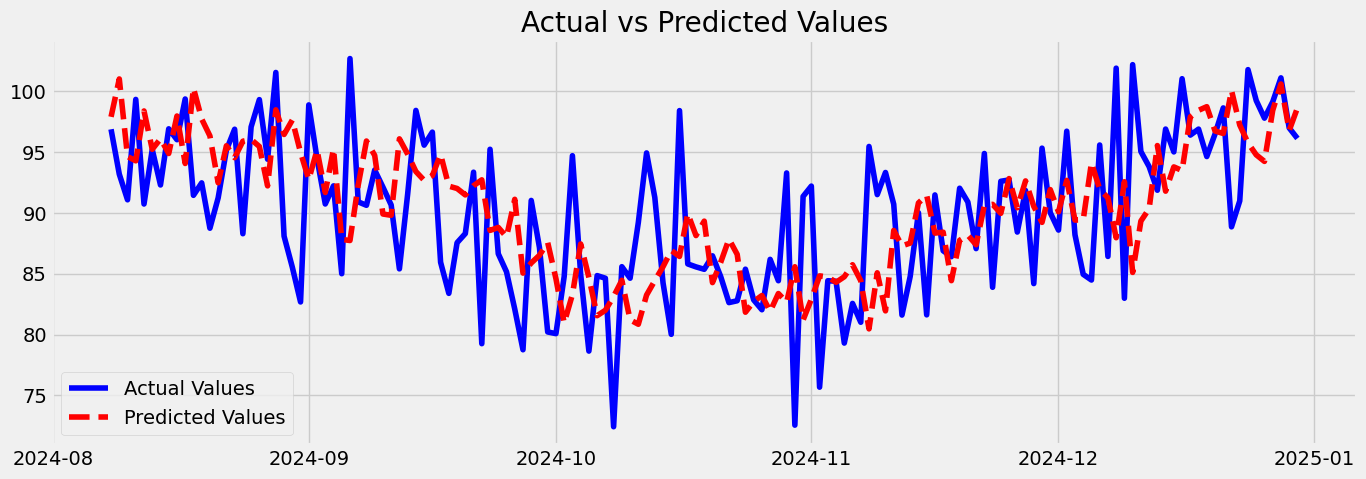

In [103]:
# Step 7: Visualize Predictions
# Finally, plot the actual values vs. the predicted values to visualize how well the model performs.
# Visualize the actual vs predicted values
plt.figure(figsize=(15,5))
plt.plot(y_test.index, y_test, label='Actual Values', color='blue')
plt.plot(y_test.index, y_pred_test, label='Predicted Values', color='red', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()


### Forecasting Future Values
###### To forecast future values beyond the test set, you can use the model to make recursive predictions:

1. Use the last known values (from the test set) to predict the next time step.
2. Use this predicted value (along with previous actual/predicted values) to predict the next step, and so on.

C:\Users\xps\anaconda3\envs\MLDL\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\xps\anaconda3\envs\MLDL\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\xps\anaconda3\envs\MLDL\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\xps\anaconda3\envs\MLDL\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\xps\anaconda3\envs\MLDL\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\xps\anaconda3\en

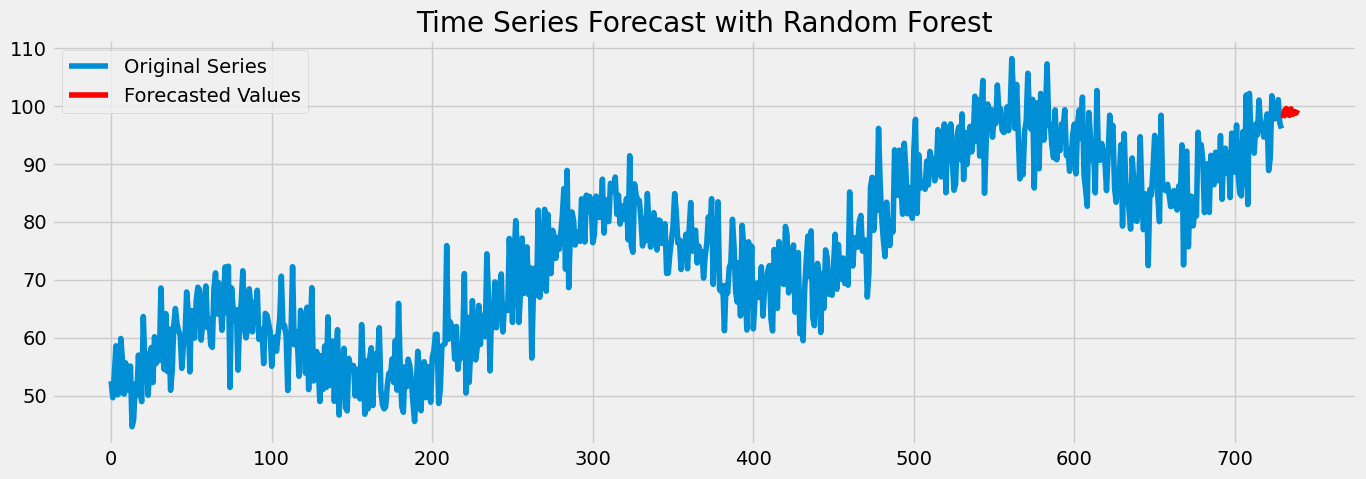

In [104]:
# Forecasting future values (1 step ahead)
n_forecast = 10
forecast_values = []
last_values = list(y_test[-lag:])  # Get the last known values from the test set

for i in range(n_forecast):
    X_forecast = np.array(last_values[-lag:]).reshape(1, -1)
    next_value = model.predict(X_forecast)[0]
    forecast_values.append(next_value)
    last_values.append(next_value)  # Append the predicted value for recursive forecasting

# Plot the forecasted values
plt.figure(figsize=(15,5))
plt.plot(np.arange(len(ts)), ts['Energy Consumption (kWh)'], label='Original Series')
plt.plot(np.arange(len(ts), len(ts) + n_forecast), forecast_values, label='Forecasted Values', color='red')
plt.title('Time Series Forecast with Random Forest')
plt.legend()
plt.show()


# Using Class and functions

Shape of Time Series: (730, 1)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2023-01-01 to 2024-12-30
Data columns (total 1 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Energy Consumption (kWh)  730 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


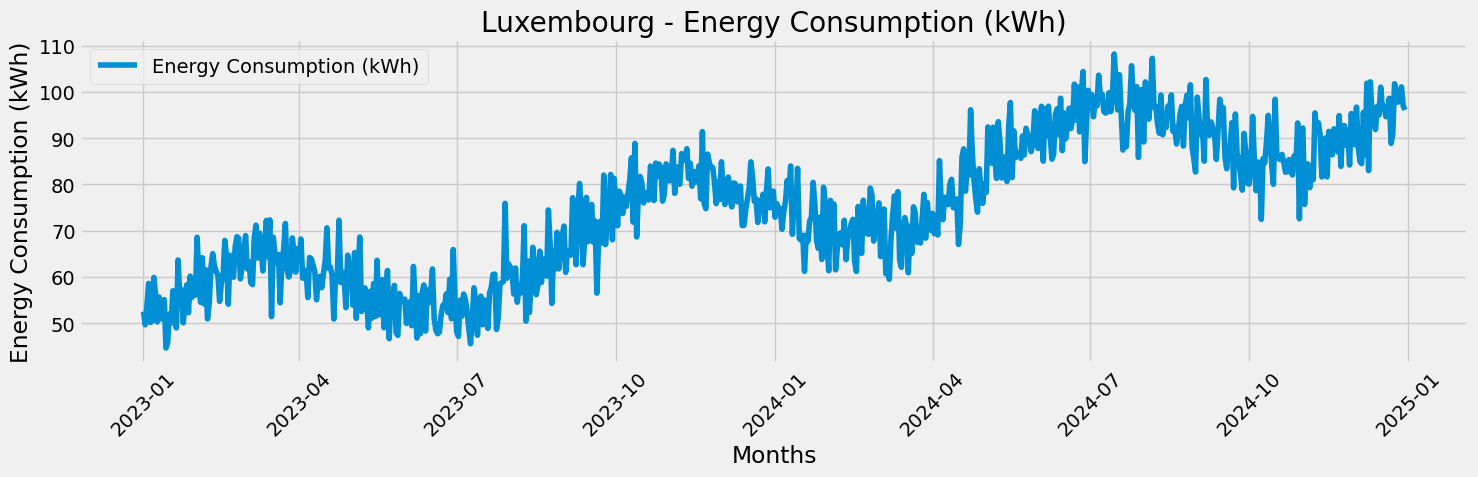

Train MSE: 4.5810
Test MSE: 36.9841


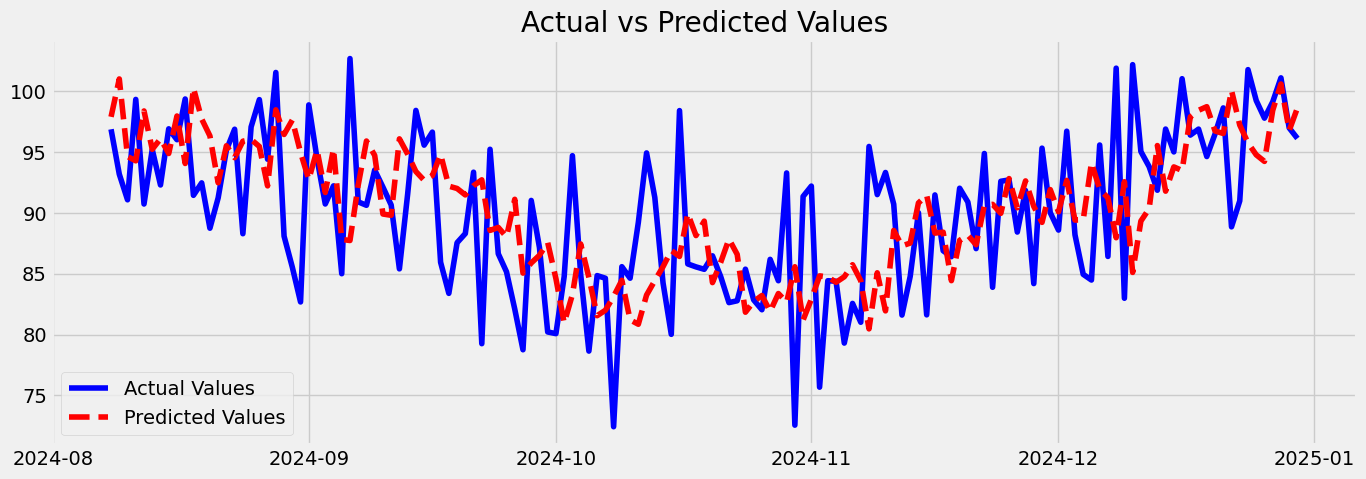

C:\Users\xps\anaconda3\envs\MLDL\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\xps\anaconda3\envs\MLDL\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\xps\anaconda3\envs\MLDL\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\xps\anaconda3\envs\MLDL\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\xps\anaconda3\envs\MLDL\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\xps\anaconda3\en

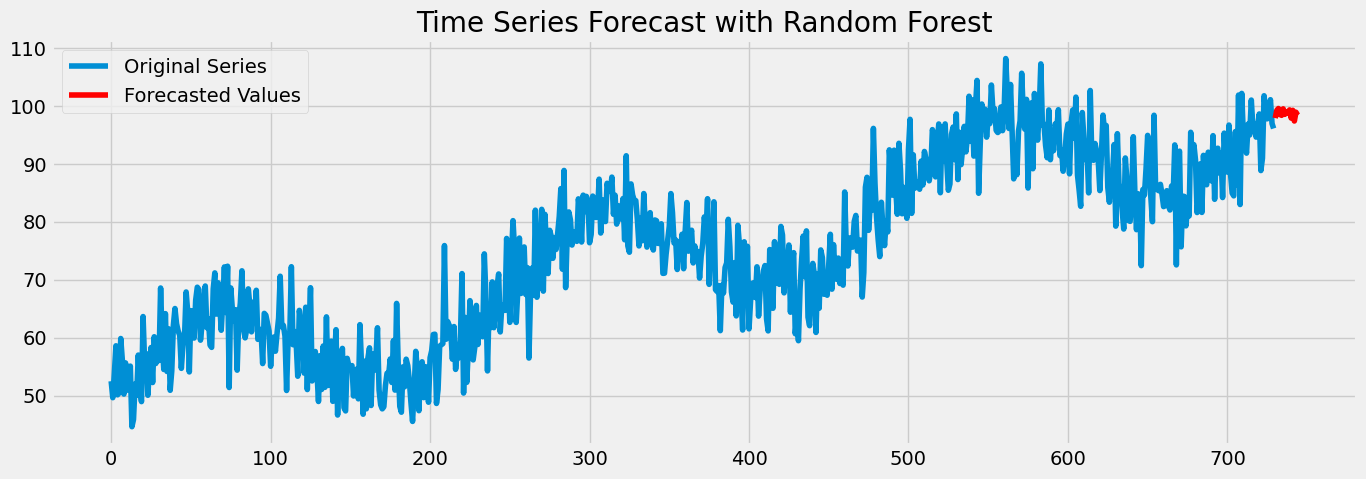

In [105]:
# Import necessary packages
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

class TimeSeriesForecaster:
    def __init__(self, data, target_col, lag=7, test_size=0.2, n_estimators=100, random_state=0):
        self.data = data.dropna()  # Clean the data (remove missing values)
        self.target_col = target_col  # Target column (e.g. 'Energy Consumption (kWh)')
        self.lag = lag  # Number of lag features to use
        self.test_size = test_size  # Test set proportion
        self.model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)  # Random Forest model
        self.X_train, self.X_test, self.y_train, self.y_test = None, None, None, None  # Data split holders

    def create_lag_features(self):
        """Creates lag features for the time series dataset."""
        ts_lag = self.data.copy()
        for i in range(1, self.lag + 1):
            ts_lag[f'lag_{i}'] = ts_lag[self.target_col].shift(i)
        ts_lag.dropna(inplace=True)  # Remove rows with NaN values
        return ts_lag

    def split_data(self, ts_lag):
        """Splits the dataset into training and testing sets based on time."""
        X = ts_lag.drop(self.target_col, axis=1)  # Features
        y = ts_lag[self.target_col]  # Target
        train_size = int(len(X) * (1 - self.test_size))  # Training size based on time series
        self.X_train, self.X_test = X[:train_size], X[train_size:]
        self.y_train, self.y_test = y[:train_size], y[train_size:]

    def train_model(self):
        """Trains the Random Forest model."""
        self.model.fit(self.X_train, self.y_train)

    def evaluate_model(self):
        """Evaluates the model using Mean Squared Error."""
        y_pred_train = self.model.predict(self.X_train)
        y_pred_test = self.model.predict(self.X_test)
        train_mse = mean_squared_error(self.y_train, y_pred_train)
        test_mse = mean_squared_error(self.y_test, y_pred_test)
        print(f'Train MSE: {train_mse:.4f}')
        print(f'Test MSE: {test_mse:.4f}')
        return y_pred_test

    def visualize_predictions(self, y_pred_test):
        """Visualizes actual vs predicted values."""
        plt.figure(figsize=(15,5))
        plt.plot(self.y_test.index, self.y_test, label='Actual Values', color='blue')
        plt.plot(self.y_test.index, y_pred_test, label='Predicted Values', color='red', linestyle='--')
        plt.title('Actual vs Predicted Values')
        plt.legend()
        plt.show()

    def forecast_future(self, n_forecast=30):
        """Forecasts future values using recursive forecasting."""
        forecast_values = []
        last_values = list(self.y_test[-self.lag:])  # Get the last known values from the test set

        for _ in range(n_forecast):
            X_forecast = np.array(last_values[-self.lag:]).reshape(1, -1)
            next_value = self.model.predict(X_forecast)[0]
            forecast_values.append(next_value)
            last_values.append(next_value)  # Add the predicted value for the next iteration

        # Plot the forecasted values
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(len(self.data)), self.data[self.target_col], label='Original Series')
        plt.plot(np.arange(len(self.data), len(self.data) + n_forecast), forecast_values, label='Forecasted Values', color='red')
        plt.title('Time Series Forecast with Random Forest')
        plt.legend()
        plt.show()

# Main Execution
if __name__ == "__main__":
    # Step 1: Load and inspect the dataset
    ts = pd.read_csv("energy_consumption_2_years.csv", index_col='Date', parse_dates=True)
    print("Shape of Time Series:", ts.shape)
    print("\nDataset Information:")
    ts.info()

    # Plot the time series: Date vs Energy Consumption
    plt.figure(figsize=(15,5))
    plt.plot(ts.index, ts['Energy Consumption (kWh)'], label='Energy Consumption (kWh)')
    plt.title("Luxembourg - Energy Consumption (kWh)")
    plt.xlabel("Months")
    plt.ylabel("Energy Consumption (kWh)")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Step 2: Initialize the forecaster
    target_col = 'Energy Consumption (kWh)'
    forecaster = TimeSeriesForecaster(data=ts, target_col=target_col, lag=7)

    # Step 3: Create lag features
    ts_lag = forecaster.create_lag_features()

    # Step 4: Split the data into training and test sets
    forecaster.split_data(ts_lag)

    # Step 5: Train the Random Forest model
    forecaster.train_model()

    # Step 6: Evaluate the model performance
    y_pred_test = forecaster.evaluate_model()

    # Step 7: Visualize the actual vs predicted values
    forecaster.visualize_predictions(y_pred_test)

    # Step 8: Forecast future values
    forecaster.forecast_future(n_forecast=15) # 15= number of days that we want to forecast (we can update it for the period that we want to forecast)


# Multivariate Time Series

# Using Class and Functions for a Multivariate T.S.

The shape of the T.S. is:  (730, 3)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2023-01-01 to 2024-12-30
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Energy Consumption (kWh)  730 non-null    float64
 1   Temperature (C)           730 non-null    float64
 2   Humidity (%)              730 non-null    float64
dtypes: float64(3)
memory usage: 22.8 KB
Mean Squared Error for Energy Consumption (kWh): 50.24
Mean Squared Error for Temperature (C): 6.81
Mean Squared Error for Humidity (%): 35.47


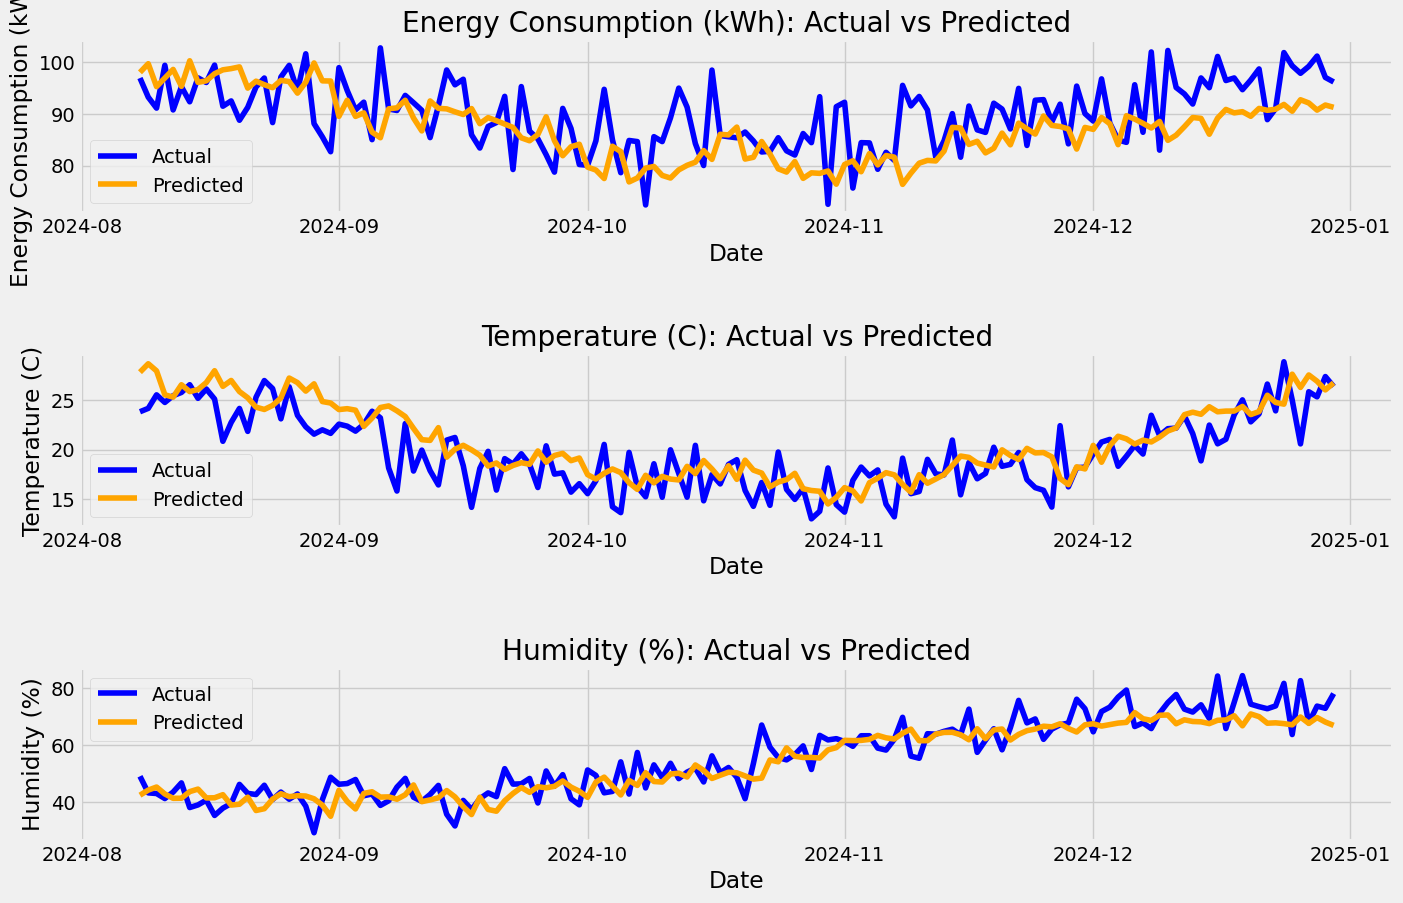

C:\Users\xps\anaconda3\envs\MLDL\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\xps\anaconda3\envs\MLDL\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\xps\anaconda3\envs\MLDL\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\xps\anaconda3\envs\MLDL\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\xps\anaconda3\envs\MLDL\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\xps\anaconda3\en

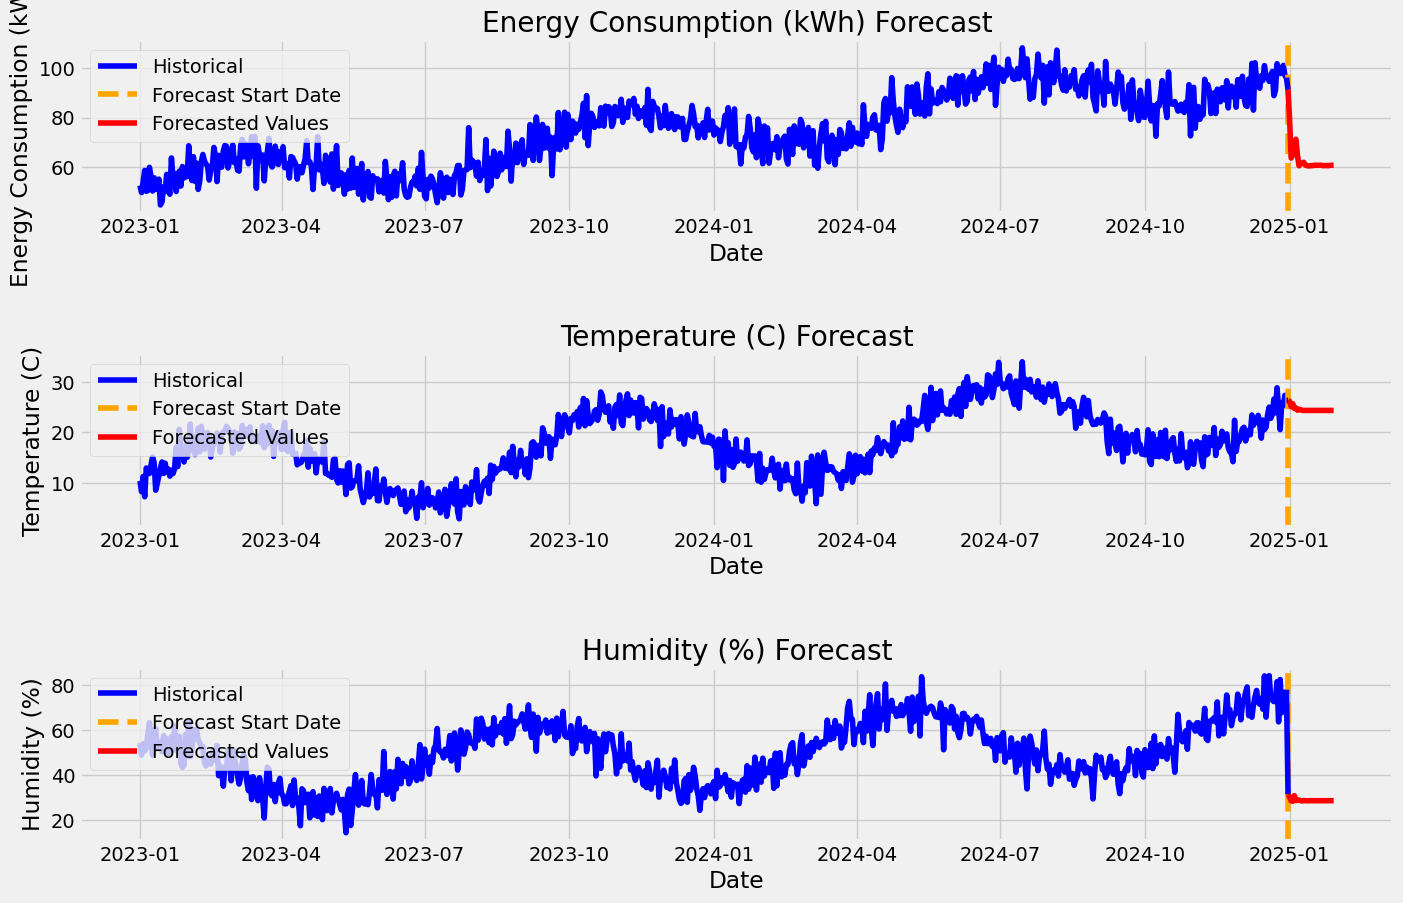

In [106]:
# Import necessary packages
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

class EnergyForecasting:
    def __init__(self, data_path, target_cols, lag=7):
        self.data_path = data_path
        self.target_cols = target_cols
        self.lag = lag
        self.models = {}
        self.ts = None
        self.ts_lag = None

    def load_data(self):
        """Load and preprocess the dataset."""
        self.ts = pd.read_csv(self.data_path, index_col='Date', parse_dates=True)
        self.ts = self.ts.dropna()  # Drop the missing values
        print("The shape of the T.S. is: ", self.ts.shape)
        print("\n")
        self.ts.info()

    def create_lag_features(self):
        """Create lagged features for the target columns."""
        ts_lag = self.ts.copy()
        for col in self.target_cols:
            for i in range(1, self.lag + 1):
                ts_lag[f'{col}_lag_{i}'] = ts_lag[col].shift(i)
        ts_lag.dropna(inplace=True)  # Drop rows with NaN values caused by the lag
        self.ts_lag = ts_lag

    def split_data(self):
        """Split data into training and test sets."""
        X = self.ts_lag.drop(self.target_cols, axis=1)  # Features (lagged values)
        y = self.ts_lag[self.target_cols]  # Target variables

        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        
        return X_train, X_test, y_train, y_test

    def train_models(self, X_train, y_train):
        """Train Random Forest Regressors for each target variable."""
        for target in self.target_cols:
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_train, y_train[target])
            self.models[target] = model

    def make_predictions(self, X_test):
        """Make predictions for each target variable."""
        y_pred = pd.DataFrame(index=X_test.index)
        for target in self.target_cols:
            y_pred[target] = self.models[target].predict(X_test)
        return y_pred

    def evaluate_models(self, y_test, y_pred):
        """Evaluate the models using Mean Squared Error."""
        for target in self.target_cols:
            mse = mean_squared_error(y_test[target], y_pred[target])
            print(f'Mean Squared Error for {target}: {mse:.2f}')

    def visualize_predictions(self, y_test, y_pred):
        """Visualize predictions vs actual values."""
        plt.figure(figsize=(15, 10))

        for i, target in enumerate(self.target_cols, start=1):
            plt.subplot(len(self.target_cols), 1, i)
            plt.plot(y_test.index, y_test[target], label='Actual', color='blue')
            plt.plot(y_test.index, y_pred[target], label='Predicted', color='orange')
            plt.title(f'{target}: Actual vs Predicted')
            plt.xlabel('Date')
            plt.ylabel(target)
            plt.legend()

        plt.tight_layout(pad=3.0)
        plt.show()

    def forecast_future(self, n_forecast=30):
        """Forecast future values for each target variable."""
        future_predictions = {target: [] for target in self.target_cols}
        
        latest_data = self.ts_lag.iloc[-1].drop(self.target_cols).values.reshape(1, -1)  # Get the last row without target values
        
        for _ in range(n_forecast):
            for target in self.target_cols:
                next_value = self.models[target].predict(latest_data)[0]
                future_predictions[target].append(next_value)

                # Update latest_data for next prediction
                latest_data = np.roll(latest_data, shift=-1)
                latest_data[0, -1] = next_value  # Assign the predicted value to the last feature
                for i in range(1, self.lag + 1):
                    latest_data[0, -i] = self.ts_lag.iloc[-1][f'{target}_lag_{i}'] if i < self.lag else next_value
        
        return future_predictions

    def plot_forecast(self, future_predictions, historical_data):
        """Plot historical data and forecasted values."""
        future_dates = pd.date_range(start=self.ts.index[-1] + pd.Timedelta(days=1), periods=len(future_predictions[self.target_cols[0]]), freq='D')
        future_predictions_df = pd.DataFrame(future_predictions, index=future_dates)

        plt.figure(figsize=(15, 10))

        for i, target in enumerate(self.target_cols, start=1):
            plt.subplot(len(self.target_cols), 1, i)
            plt.plot(historical_data.index, historical_data[target], label='Historical', color='blue')
            plt.axvline(future_dates[0], color='orange', linestyle='--', label='Forecast Start Date')

            # Connect the last historical value with the first forecasted value
            last_historical_value = historical_data[target].iloc[-1]
            plt.plot([historical_data.index[-1], future_dates[0]], [last_historical_value, future_predictions_df[target].iloc[0]], color='blue', linestyle='-')

            plt.plot(future_dates, future_predictions_df[target], color='red', label='Forecasted Values', linestyle='-')
            plt.title(f'{target} Forecast')
            plt.xlabel('Date')
            plt.ylabel(target)
            plt.legend()

        plt.tight_layout(pad=3.0)
        plt.show()

# Example of using the class
if __name__ == "__main__":
    data_path = 'multivariate_energy_data.csv'
    target_cols = ['Energy Consumption (kWh)', 'Temperature (C)', 'Humidity (%)']
    
    forecasting_model = EnergyForecasting(data_path, target_cols, lag=7)
    forecasting_model.load_data()
    forecasting_model.create_lag_features()
    X_train, X_test, y_train, y_test = forecasting_model.split_data()
    forecasting_model.train_models(X_train, y_train)
    y_pred = forecasting_model.make_predictions(X_test)
    forecasting_model.evaluate_models(y_test, y_pred)
    forecasting_model.visualize_predictions(y_test, y_pred)
    
    future_predictions = forecasting_model.forecast_future(n_forecast=30)
    forecasting_model.plot_forecast(future_predictions, forecasting_model.ts)


# 2. Extreme Gradient Boosting (XGBoost)

**Key Questions to Address:**
1. What is **XGBoost**?
2. How is it utilized?
3. Why is it significant?
4. What is the corresponding mathematical formula?
5. How can it be implemented in Python?

---
### 1. **What is XGBoost?**

**XGBoost (Extreme Gradient Boosting)** is an advanced implementation of gradient boosting, which is an ensemble machine learning technique. 
- It enhances model performance by training decision trees iteratively, where each new tree corrects the mistakes of its predecessors.
- These models are combined in a weighted manner to provide more accurate predictions.
- **XGBoost** is known for its efficiency, speed, and scalability, making it suitable for large datasets.

### 2. **How is XGBoost Utilized for Forecasting Time Series?**

In time series forecasting, XGBoost is used to model past observations (lags) as features to predict future values. Time series forecasting with XGBoost is treated as a regression problem, where:
- **Past values (lags)** of the time series are used as features.
- The **future value** is the output (target).

Key steps:
- **Feature Engineering**: Create lagged features, such as values at time $t-1, t-2$, etc.
- **Train-Test Split**: Ensure no data leakage by ensuring the test set is forward in time (no shuffling).
- **Model Training**: Train XGBoost as a supervised learning model using the lagged features and labels.
- **Prediction**: Use the trained model to forecast based on previous patterns.

### 3. **Why is it Significant?**

XGBoost’s significance in time series forecasting lies in:
- **Efficiency**: It uses optimized computational techniques like parallel processing, making it very fast.
- **Regularization**: Built-in regularization (L1 and L2) prevents overfitting, especially useful when dealing with noisy time series data.
- **Scalability**: Can handle very large datasets, important for large-scale time series analysis.
- **Accuracy**: Often more accurate than traditional time series models like ARIMA because it can model complex, non-linear relationships.

### 4. **What is the Corresponding Mathematical Formula?**

XGBoost optimizes the following objective function:

$$
\mathcal{L}(\theta) = \sum_{i=1}^{n} \ell(y_i, \hat{y}_i^{(t)}) + \sum_{k=1}^{T} \Omega(f_k)
$$

Where:
- $\mathcal{L}(\theta)$ is the loss function (e.g., Mean Squared Error).
- $\ell(y_i, \hat{y}_i^{(t)})$ is the loss between the actual value \( y_i \) and the predicted value \( \hat{y}_i^{(t)} \) at iteration \( t \).
- $\Omega(f_k)$ is the regularization term for the complexity of the \( k \)-th tree \( f_k \), controlling model complexity (e.g., number of leaves).

---
**Note:**
- The trees are trained to minimize this objective function using gradient descent, where the predictions from previous trees are combined with the new one to improve performance.


### 1. Univariate Time Series

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
color_pal = sns.color_palette() # import the olor paletter from seaborn

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [108]:
# Download the dataset
df = pd.read_csv("PJME_hourly.csv")
df = df.set_index('Datetime')
df.index # as we can notice it's an "object" (dtype='object')
# We need/  must to convert it to datetime
df.index = pd.to_datetime(df.index) # dtype='datetime64[ns]' =>  It heps for good and clear visualization in xlabel 

# Sort the DataFrame by index (Datetime) to enable proper slicing
df = df.sort_index()

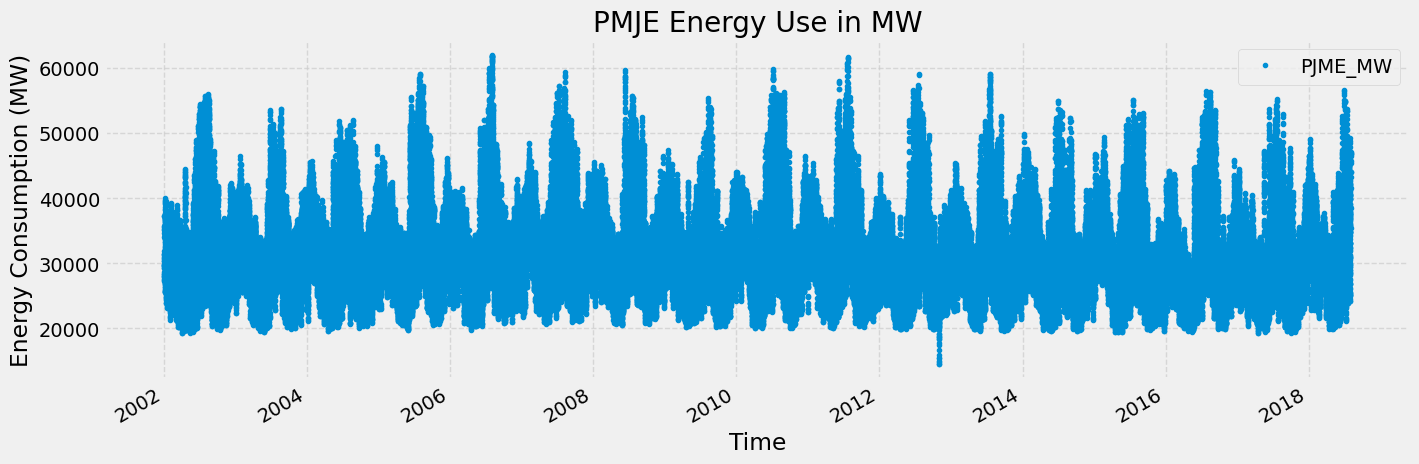

In [109]:
# Visualize the time serie
df.plot(
    style='.',                       # Use dots to represent data points in the plot
    figsize=(15, 5),                 # Set the size of the plot (width=15, height=5)
    color=color_pal[0],              # Choose a color for the plot (can be modified as needed)
    title='PMJE Energy Use in MW',   # Title of the plot
    xlabel='Time',                   # Label for the x-axis
    ylabel='Energy Consumption (MW)' # Label for the y-axis
)
plt.grid(visible=True, linestyle='--', alpha=0.7) # Deactivate the grid use 'False
plt.show()


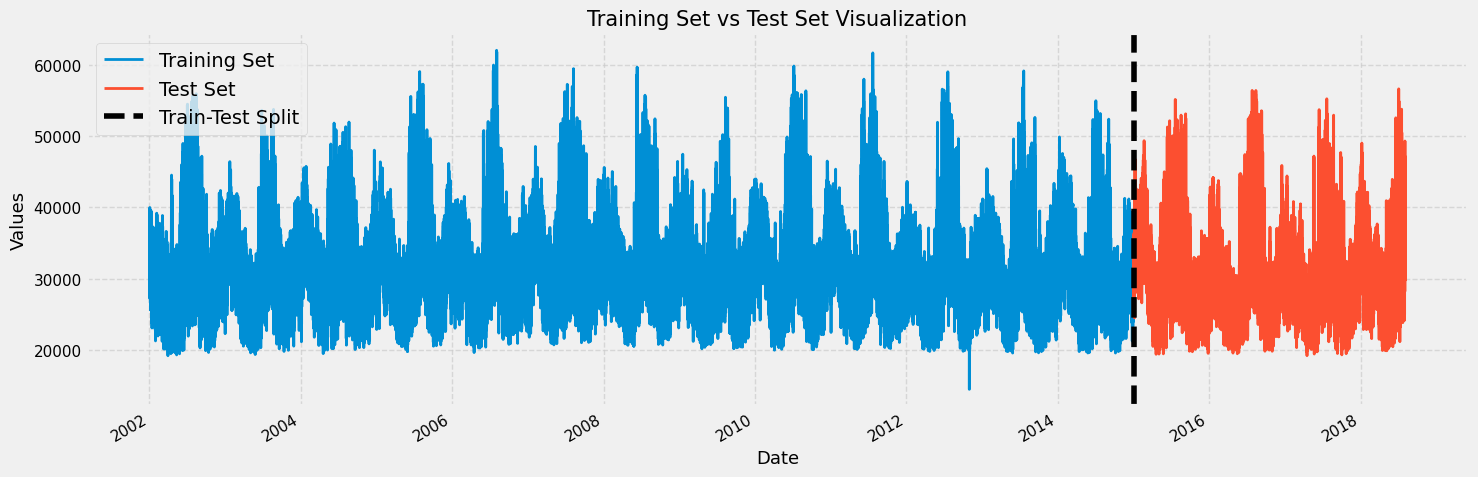

In [110]:
# Train/Test Split
train = df.loc[df.index< '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

# Visualize the training set and the test set using subplot technique
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training set', linewidth=2) #train.plot(ax=ax, label='Training Set', color='blue', linewidth=2)
test.plot(ax=ax, label='Test set', linewidth=2)
ax.axvline('01-01-2015', color='black', linestyle='--', label='Train-Test Split')
ax.legend(['Training Set','Test Set', 'Train-Test Split'])

# Set titles and labels
ax.set_title('Training Set vs Test Set Visualization', fontsize=15)
ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('Values', fontsize=13)

# Customize grid and ticks for better readability
ax.grid(visible=True, linestyle='--', alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=11)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

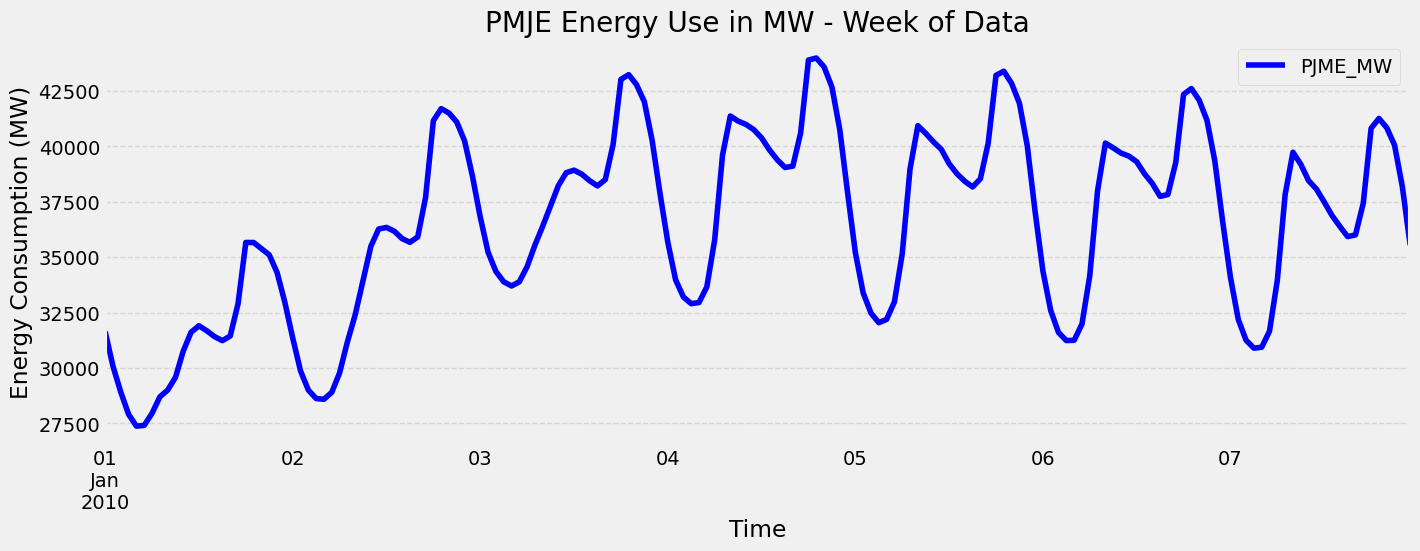

In [111]:
# Visualize a consumption of 'One week'
# Step 1: Define the date range for visualization
start_date = '2010-01-01'
end_date = '2010-01-08'

# Step 2: Filter the DataFrame for the specified date range
filtered_data = df.loc[(df.index >= start_date) & (df.index < end_date)]

# Step 3: Visualize the filtered data
filtered_data.plot(
    style='-',                       # Use dots to represent data points in the plot
    figsize=(15, 5),                 # Set the size of the plot (width=15, height=5)
    color='blue',                   # Choose a color for the plot (can be modified as needed)
    title='PMJE Energy Use in MW - Week of Data',  # Title of the plot
    xlabel='Time',                   # Label for the x-axis
    ylabel='Energy Consumption (MW)' # Label for the y-axis
)

# Step 4: Customize grid and show the plot
plt.grid(visible=True, linestyle='--', alpha=0.7)  # Optional: You can set 'visible=False' to deactivate the grid
plt.show()

In [112]:
# Feature Creation
def create_features(df):
    """ Create a time series features based on time series index."""
    df = df.copy()
    df['Hour'] = df.index.hour
    df['Day_Of_Week'] = df.index.day_of_week
    df['Quarter'] = df.index.quarter
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['Day_Of_Year'] = df.index.dayofyear
    return df
    
# Run the function on the df
df = create_features(df)

C:\Users\xps\AppData\Local\Temp\ipykernel_14432\1822351295.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Hour', y='PJME_MW', palette=color_pal)
C:\Users\xps\AppData\Local\Temp\ipykernel_14432\1822351295.py:5: UserWarning: 
The palette list has fewer values (6) than needed (24) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=df, x='Hour', y='PJME_MW', palette=color_pal)


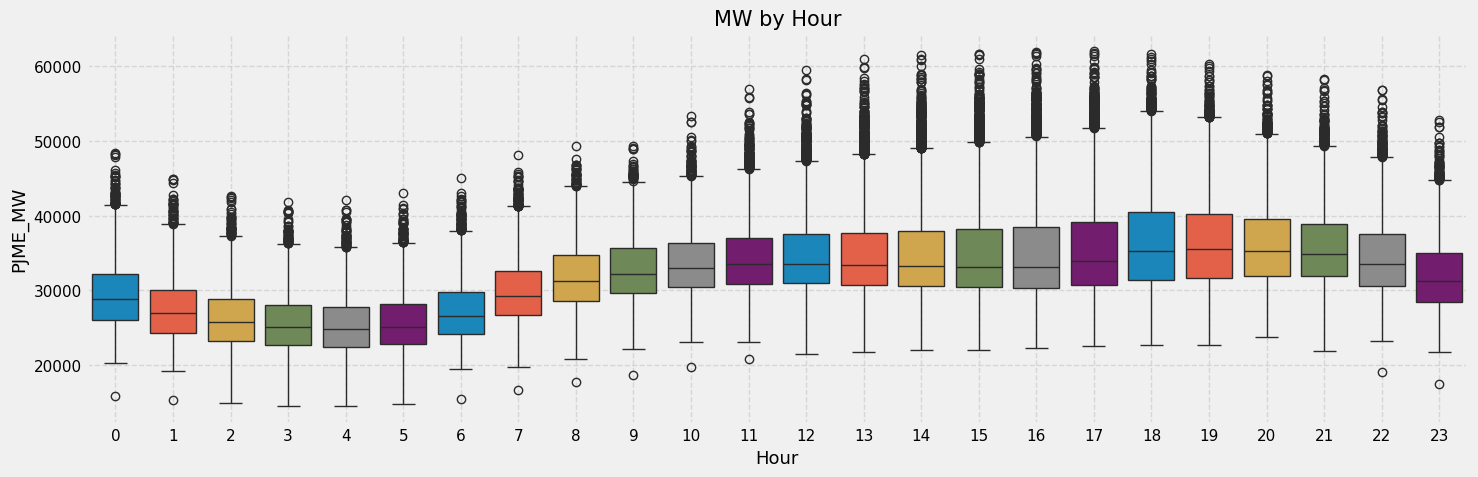

In [113]:
# Visualize the Feature /Target Relationship ("by Hour")
# It give us an idea about the distribution of the dataset

fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x='Hour', y='PJME_MW', palette=color_pal)
# Set titles and labels
ax.set_title('MW by Hour', fontsize=15)
ax.set_xlabel('Hour', fontsize=13)
ax.set_ylabel('PJME_MW', fontsize=13)

# Customize grid and ticks for better readability
ax.grid(visible=True, linestyle='--', alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=11)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

C:\Users\xps\AppData\Local\Temp\ipykernel_14432\992315895.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Month', y='PJME_MW', palette=color_pal)
C:\Users\xps\AppData\Local\Temp\ipykernel_14432\992315895.py:5: UserWarning: 
The palette list has fewer values (6) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=df, x='Month', y='PJME_MW', palette=color_pal)


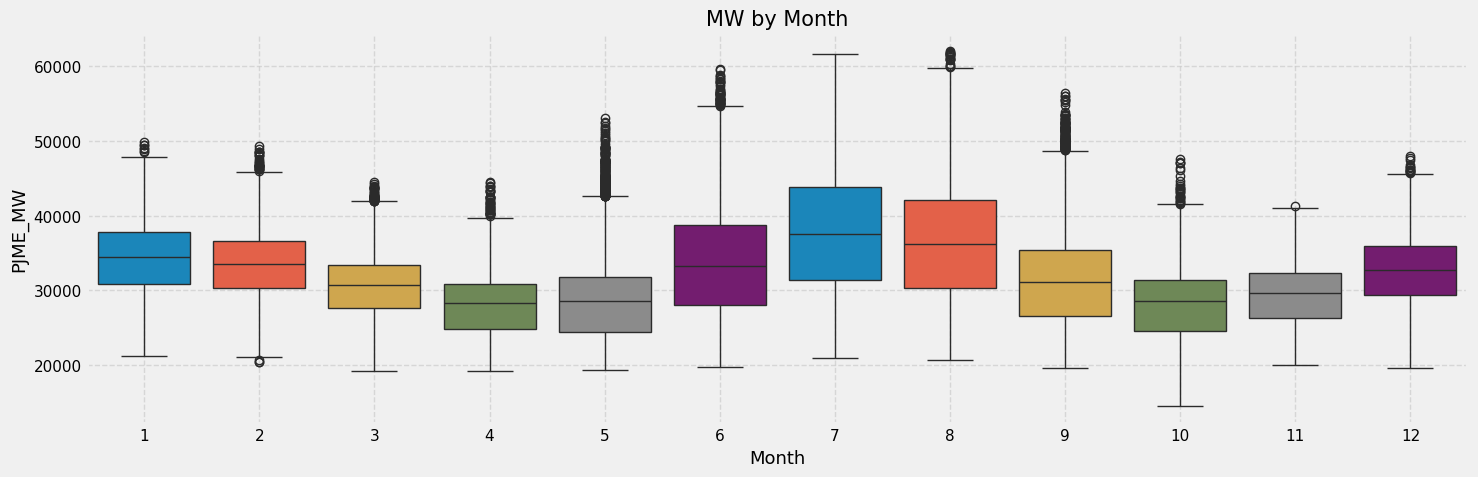

In [114]:
# Visualize the Feature /Target Relationship ("by Month")
# It give us an idea about the distribution of the dataset

fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x='Month', y='PJME_MW', palette=color_pal)
# Set titles and labels
ax.set_title('MW by Month', fontsize=15)
ax.set_xlabel('Month', fontsize=13)
ax.set_ylabel('PJME_MW', fontsize=13)

# Customize grid and ticks for better readability
ax.grid(visible=True, linestyle='--', alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=11)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

C:\Users\xps\AppData\Local\Temp\ipykernel_14432\145717217.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Year', y='PJME_MW', palette=color_pal)
C:\Users\xps\AppData\Local\Temp\ipykernel_14432\145717217.py:5: UserWarning: 
The palette list has fewer values (6) than needed (17) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=df, x='Year', y='PJME_MW', palette=color_pal)


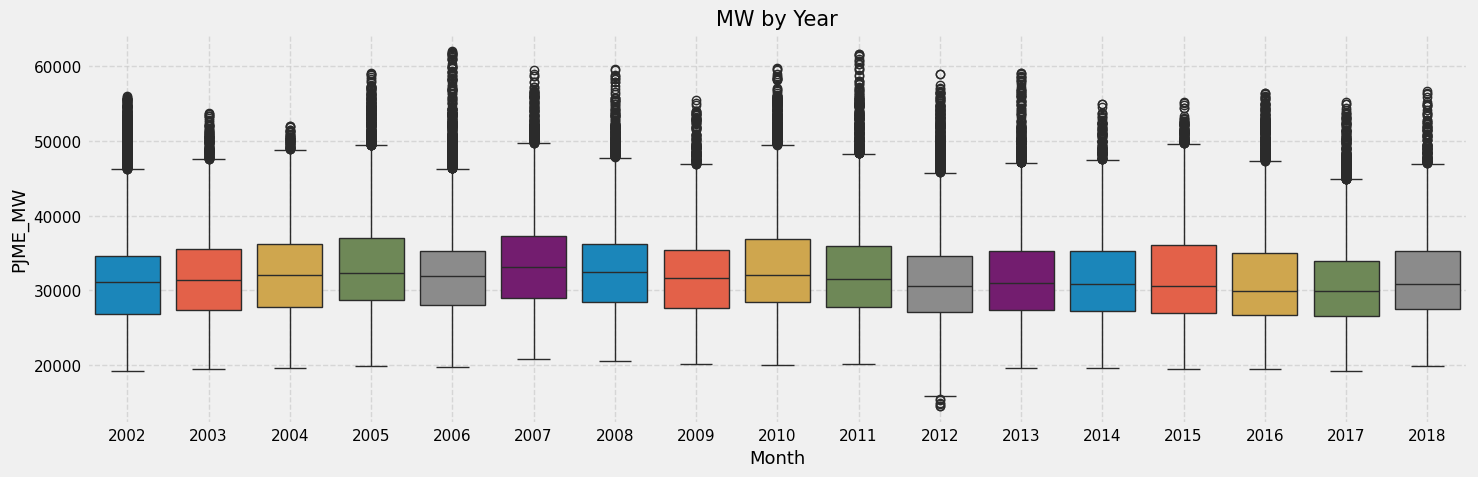

In [115]:
# Visualize the Feature /Target Relationship ("by Year")
# It give us an idea about the distribution of the dataset

fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x='Year', y='PJME_MW', palette=color_pal)
# Set titles and labels
ax.set_title('MW by Year', fontsize=15)
ax.set_xlabel('Month', fontsize=13)
ax.set_ylabel('PJME_MW', fontsize=13)

# Customize grid and ticks for better readability
ax.grid(visible=True, linestyle='--', alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=11)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

C:\Users\xps\AppData\Local\Temp\ipykernel_14432\2241058276.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Day_Of_Week', y='PJME_MW', palette=color_pal)
C:\Users\xps\AppData\Local\Temp\ipykernel_14432\2241058276.py:5: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=df, x='Day_Of_Week', y='PJME_MW', palette=color_pal)


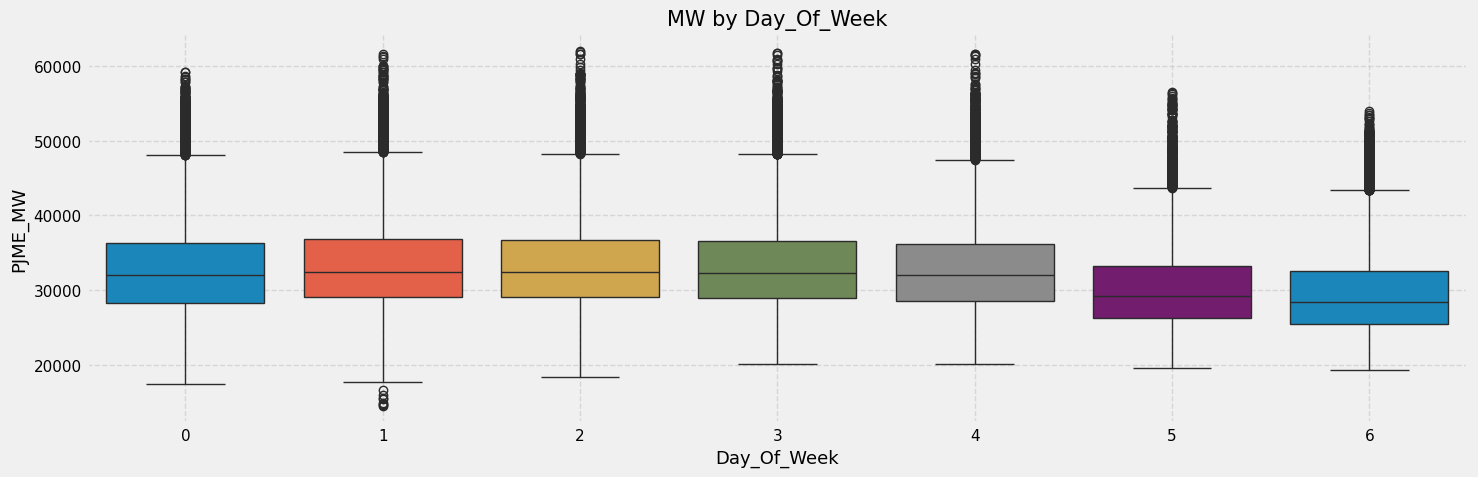

In [116]:
# Visualize the Feature /Target Relationship ("by Day_Of_Week")
# It give us an idea about the distribution of the dataset

fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x='Day_Of_Week', y='PJME_MW', palette=color_pal)
# Set titles and labels
ax.set_title('MW by Day_Of_Week', fontsize=15)
ax.set_xlabel('Day_Of_Week', fontsize=13)
ax.set_ylabel('PJME_MW', fontsize=13)

# Customize grid and ticks for better readability
ax.grid(visible=True, linestyle='--', alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=11)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

C:\Users\xps\AppData\Local\Temp\ipykernel_14432\703136788.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Quarter', y='PJME_MW', palette=color_pal)
C:\Users\xps\AppData\Local\Temp\ipykernel_14432\703136788.py:5: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.boxplot(data=df, x='Quarter', y='PJME_MW', palette=color_pal)


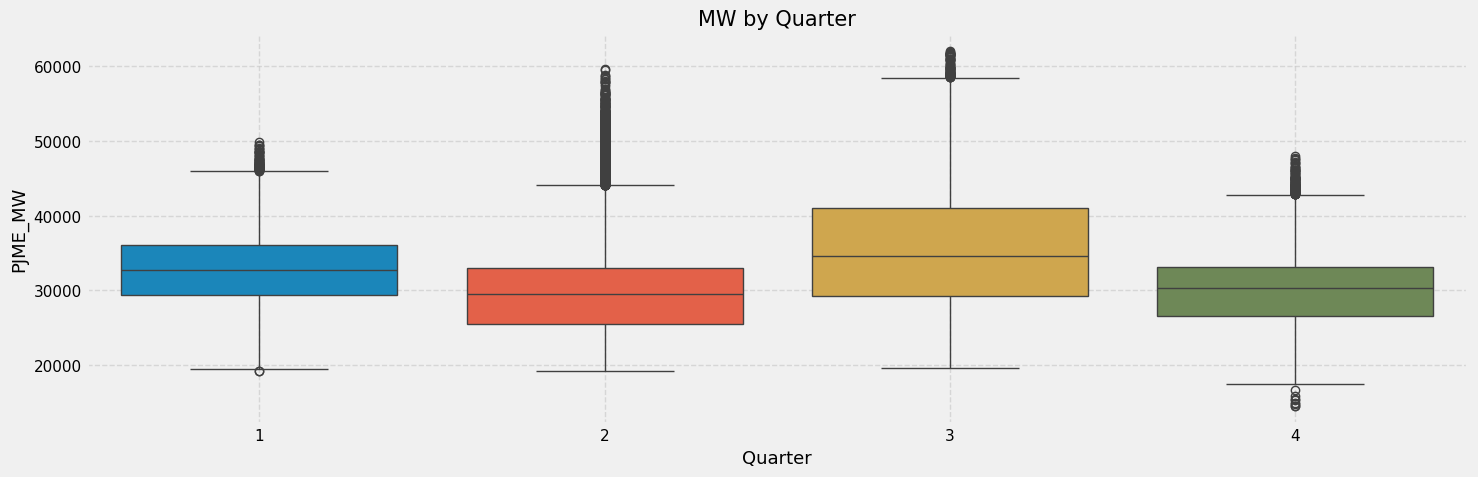

In [117]:
# Visualize the Feature /Target Relationship ("by Quarter")
# It give us an idea about the distribution of the dataset

fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x='Quarter', y='PJME_MW', palette=color_pal)
# Set titles and labels
ax.set_title('MW by Quarter', fontsize=15)
ax.set_xlabel('Quarter', fontsize=13)
ax.set_ylabel('PJME_MW', fontsize=13)

# Customize grid and ticks for better readability
ax.grid(visible=True, linestyle='--', alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=11)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [118]:
# check xgboost version
print(xgb.__version__)

2.1.1


In [119]:
# Train/Test split

train = create_features(train)
test = create_features(test)
df.columns # to see the different columns of the df
FEATURES = ['Hour', 'Day_Of_Week', 'Quarter', 'Month', 'Year','Day_Of_Year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
X_test = test[FEATURES]

y_train = train[TARGET]
y_test = test[TARGET]

In [120]:
# Create the Model
# Our problem is a regression test, so
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01) #learning_rate=0.001: we added it to avoid overfitting
reg.fit(X_train, 
        y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose=100) # beside of "True" we associated it to "100" to give us the "rmse" for validation/Test set each "100" trees has been build
        

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[417]	validation_0-rmse:2801.66222	validation_1-rmse:3749.26089


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [121]:
# Feature Importances
""" 
reg.feature_importances_ is a vital attribute that helps in understanding and interpreting the contribution of different features in a ML model.
It serves as a tool for feature selection, model interpretation, and enhancing the overall performance of predictive models.
"""
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['Importance'])
fi

,Importance
Hour,0.463878
Day_Of_Week,0.162005
Quarter,0.028881
Month,0.203161
Year,0.023824
Day_Of_Year,0.118251


<Axes: title={'center': 'Feature Importance'}>

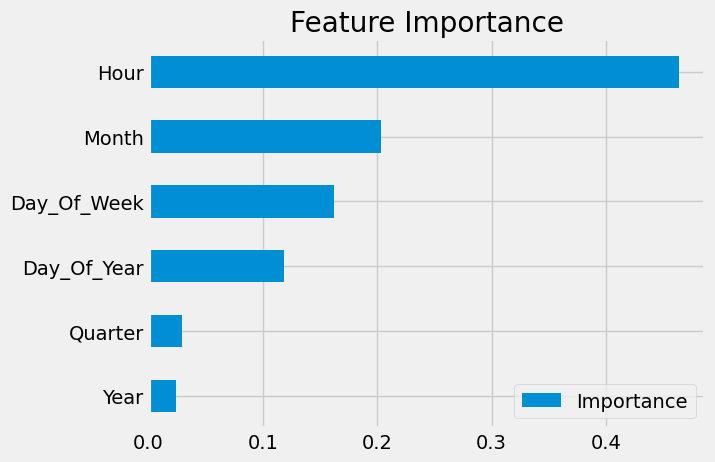

In [122]:
# Visualize Feature Importance
fi.sort_values('Importance').plot(kind='barh', title='Feature Importance')

In [123]:
# Forecast on Test Set
test['Prediction'] = reg.predict(X_test)
# Merge the 'Prediction" in the df
df = df.merge(test[['Prediction']], how='left', left_index=True, right_index=True)

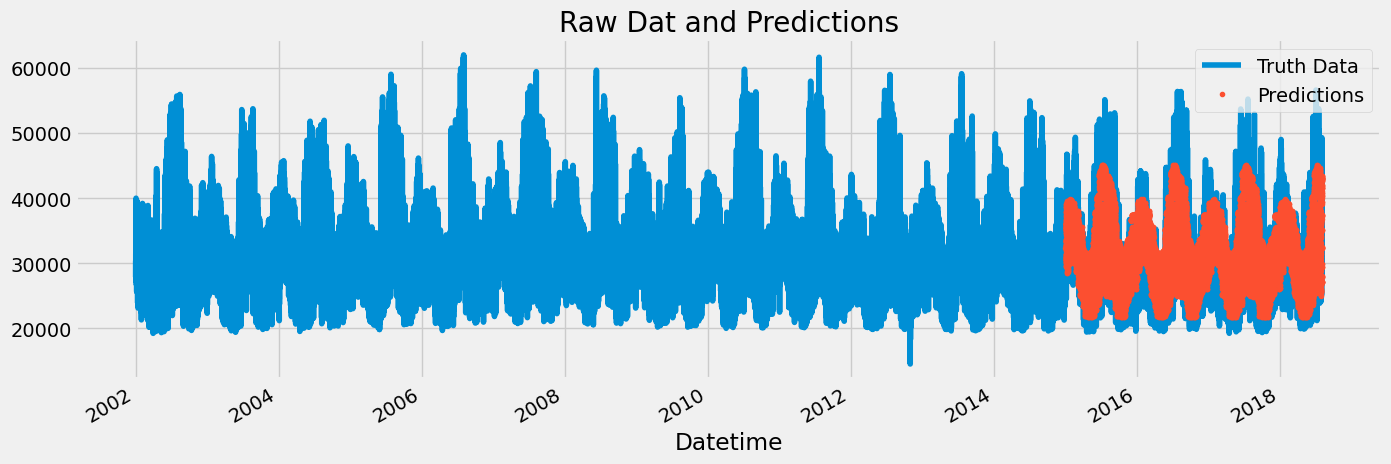

In [124]:
# Visualization
ax = df[['PJME_MW']].plot(figsize=(15,5))
df['Prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Predictions')
plt.show()

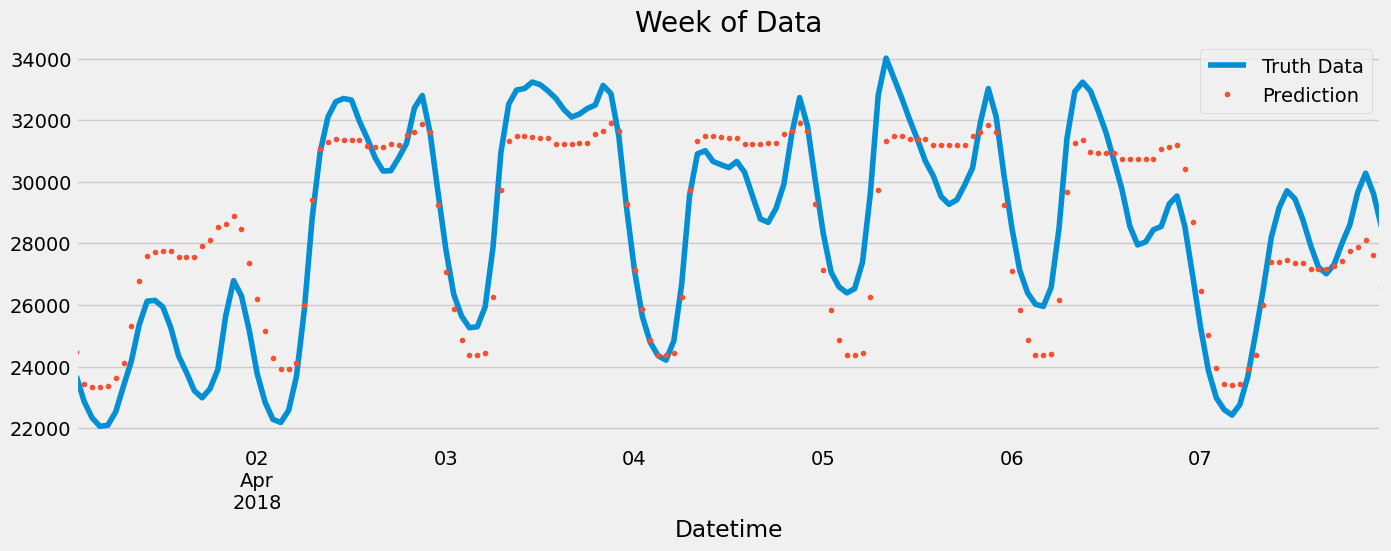

In [125]:
# One Week Prediction
# Visualize a consumption of 'One week'
# Step 1: Define the date range for visualization
start_date = '2018-04-01'
end_date = '2018-04-08'

# Step 2: Filter the DataFrame for the specified date range
ax = df.loc[(df.index > start_date) & (df.index < end_date)]['PJME_MW'].plot(figsize=(15,5), title='Week of Data')
df.loc[(df.index > start_date) & (df.index < end_date)]['Prediction'].plot(style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

In [126]:
# Error Metrics
score = np.sqrt(mean_squared_error(y_true=test['PJME_MW'], y_pred=test['Prediction']))
print(f'RMSE score on Test Set: {score:0.2f}')

RMSE score on Test Set: 3741.03


In [127]:
# Calculate The Error
# - Look at the worst and best predicted days

test['Error'] = np.abs(test[TARGET]- test['Prediction'])
test['date'] = test.index.date

# The worst dates (this one need to be improved)
test.groupby('date')['Error'].mean().sort_values(ascending=False).head(5)
# The best dates
test.groupby('date')['Error'].mean().sort_values(ascending=True).head(5)

date
2016-12-30    395.436442
2017-10-24    413.885824
2016-10-27    440.053141
2016-04-04    440.223877
2017-05-02    453.738688
Name: Error, dtype: float64

# Next Steps:
1. More cross validation
2. Add more features (Weather forecast, holidays, ...)

### Time Series Forecasting with XGBoost - Advanced Methods

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
color_pal = sns.color_palette() # import the olor paletter from seaborn

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Outline
- Outlier Analysis.
- Forecasting horizon explained.
- Time Series Cross Validation.
- Lag Features.
- Predicting The Future

In [129]:
# Download the dataset
df = pd.read_csv("PJME_hourly.csv")
df = df.set_index('Datetime')
df.index # as we can notice it's an "object" (dtype='object')
# We need/  must to convert it to datetime
df.index = pd.to_datetime(df.index) # dtype='datetime64[ns]' =>  It heps for good and clear visualization in xlabel 

# Sort the DataFrame by index (Datetime) to enable proper slicing
df = df.sort_index()

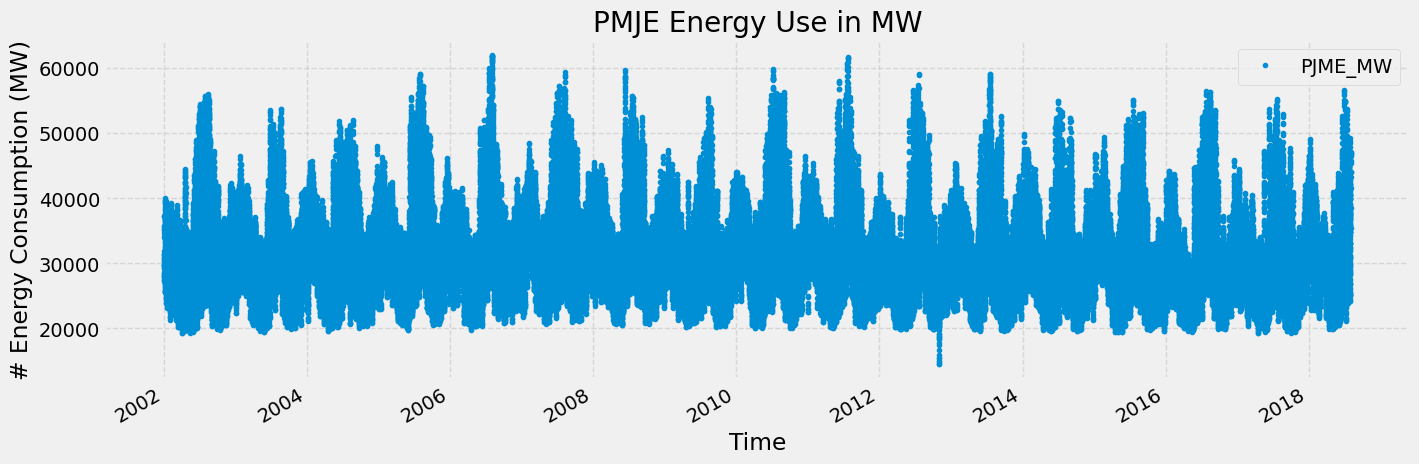

In [130]:
# Visualize the time serie
df.plot(
    style='.',                       # Use dots to represent data points in the plot
    figsize=(15, 5),                 # Set the size of the plot (width=15, height=5)
    color=color_pal[0],              # Choose a color for the plot (can be modified as needed)
    title='PMJE Energy Use in MW',   # Title of the plot
    xlabel='Time',                   # Label for the x-axis
    ylabel='# Energy Consumption (MW)' # Label for the y-axis
)
plt.grid(visible=True, linestyle='--', alpha=0.7) # Deactivate the grid use 'False
plt.show()

### Exploratory Data Analysis (EDA)
##### 1. Outlier Analysis \& Removal:

"\n# Plot histogram with KDE\nplt.figure(figsize=(12, 6))\nsns.histplot(df['PJME_MW'], bins=500, kde=True, color='blue', alpha=0.5)\nplt.title('Histogram of PJME_MW with KDE')\nplt.xlabel('PJME_MW')\nplt.ylabel('Frequency')\nplt.grid()\nplt.show()\n"

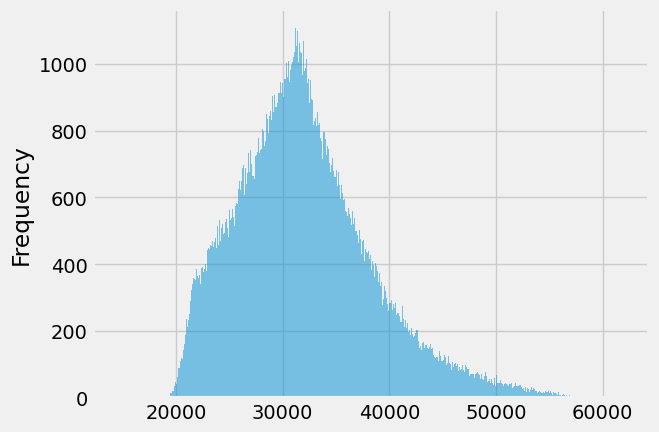

In [131]:
# Plot Histogram of this MW data
# Identify any bins with "unusually high frequencies or isolated bars", which may indicate outliers in the data
df['PJME_MW'].plot(kind='hist', alpha=0.5, bins=500)
"""
# Plot histogram with KDE
plt.figure(figsize=(12, 6))
sns.histplot(df['PJME_MW'], bins=500, kde=True, color='blue', alpha=0.5)
plt.title('Histogram of PJME_MW with KDE')
plt.xlabel('PJME_MW')
plt.ylabel('Frequency')
plt.grid()
plt.show()
"""

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

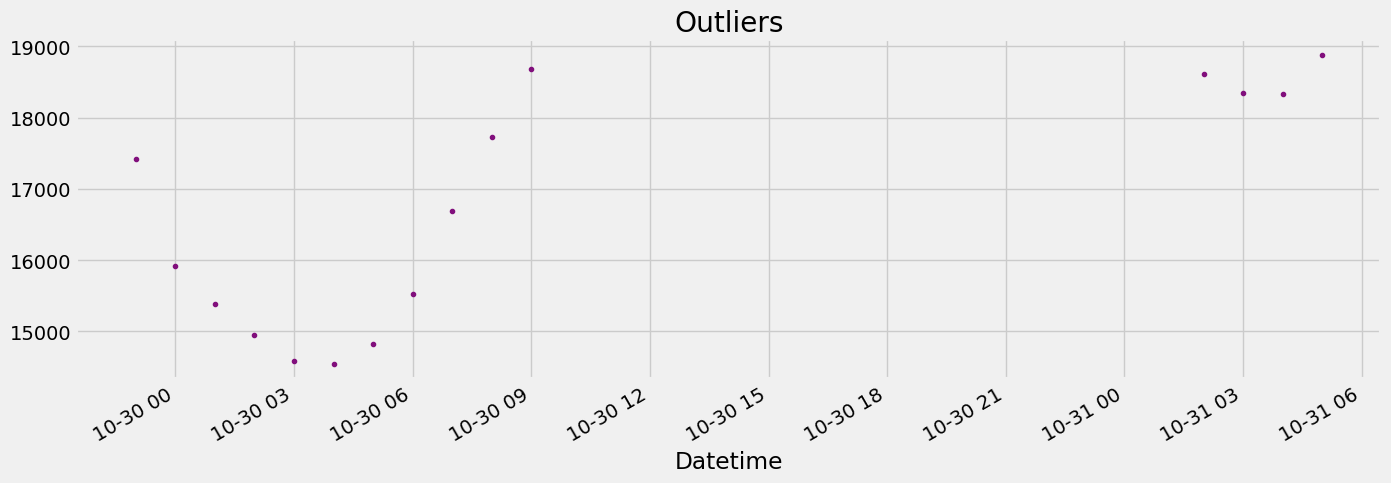

In [132]:
# Look wich outliers to remove
# Option 1: Visualy
#df.query('PJME_MW < 20_000').plot(figsize=(15,5), style='.') 

# As you can see there exist outliers in the area [2012 - 2014] where definitely are some outliers that don't look like they are ligitime.
# So trying to find a better threshold maybe less than 19_000
#df.query('PJME_MW < 19_000').plot(figsize=(15,5), style='.')
df.query('PJME_MW < 19_000')['PJME_MW'].plot(style='.',
                                             figsize=(15, 5), 
                                             color=color_pal[5], 
                                             title='Outliers')

# Now we can see that it's just these values that really dipped low that we would want to remove from our "training" and "validation'test" set

# Option 2: Computing a Statistical test (std)

In [133]:
# Creat a copy of the new df
df = df.query('PJME_MW > 19_000').copy()

##### Train / Test Split

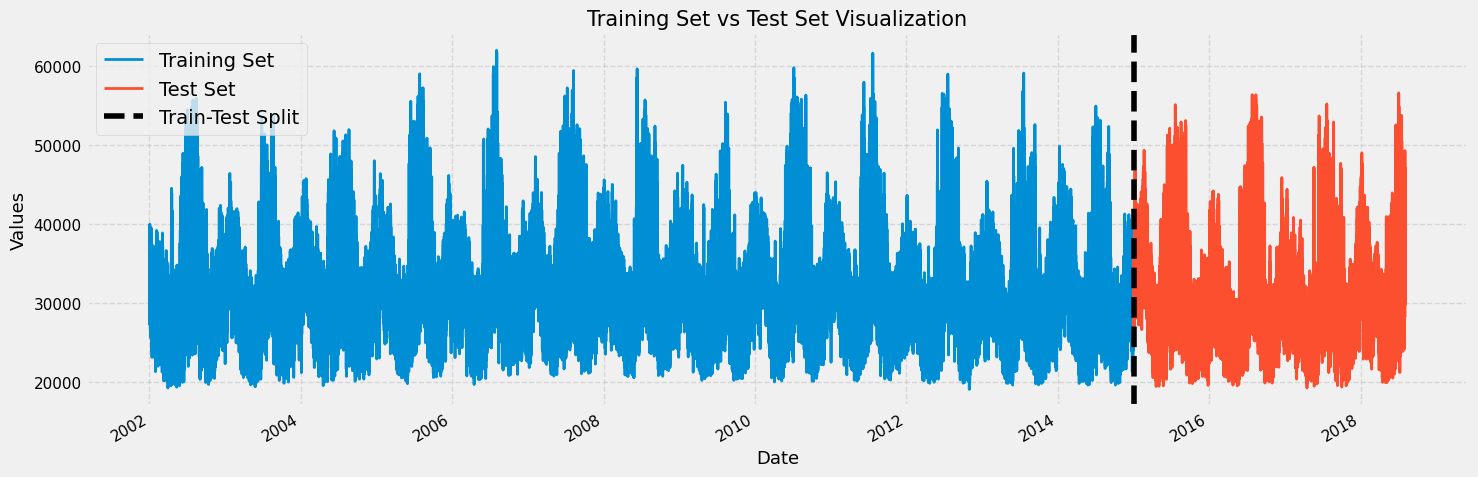

In [134]:
# Train/Test Split
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

# Visualize the training set and the test set using subplot technique
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training set', linewidth=2) #train.plot(ax=ax, label='Training Set', color='blue', linewidth=2)
test.plot(ax=ax, label='Test set', linewidth=2)
ax.axvline('01-01-2015', color='black', linestyle='--', label='Train-Test Split')
ax.legend(['Training Set','Test Set', 'Train-Test Split'])

# Set titles and labels
ax.set_title('Training Set vs Test Set Visualization', fontsize=15)
ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('Values', fontsize=13)

# Customize grid and ticks for better readability
ax.grid(visible=True, linestyle='--', alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=11)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

### Time Series Cross Validation: (best technique to split the T.S.)
- Time series cross-validation is primarily used to **split a dataset into training and test sets** in a manner that respects the temporal order of the data.
- This is crucial for evaluating the performance of predictive models on time series data because it prevents future information from leaking into the training process

##### Key Aspects of Time Series Dataset Splitting
1. Maintaining Order:
   - Unlike traditional random sampling methods, which might mix the data and disrupt the chronological order, time series validation keeps data in its original sequence.
   - This simulates how the model will be applied in real-world scenarios where predictions are made on future data based on past observations.

2. Training and Test Sets:

   - Training Set:
       - This is the portion of the data used to train the model.
       - It consists of past observations that the model uses to learn the underlying patterns and relationships.
    - Test Set:
        - This is the portion of the data that the model has never seen during training.
        - It's used to evaluate how well the model generalizes to unseen data.

In [135]:
from sklearn.model_selection import TimeSeriesSplit as TSS

# Split the Time Series (tss = time series split)
tss = TSS(n_splits=5,
          test_size=24*365*1,
          gap=24)
df = df.sort_index()

- **n_splits=5:** This parameter defines the `number of folds or splits you want for the time series cross-validation`.
    - In this case, the data will be split into 5 different training and test sets.
    - With each iteration, more of the data is used in the training set, but the order is respected.

- **test_size=24\*365\*1:** This sets the size of the test set for each split.

    - Here, `24*365*1` represents 1 year of hourly data (24 hours per day, for 365 days).
    - For each of the 5 splits, the model will be tested on 1 year's worth of data.
    - `gap=24:` This is an optional parameter that `introduces a "gap" between the training and test sets`.

        - In this case, gap=24 introduces a 24-hour gap (1 day) between the training and test sets.
        - This can be useful in time series data where the immediate next data points might be too correlated or dependent on the last points in the
          training set, or when you want to simulate a lag or buffer period between predictions.

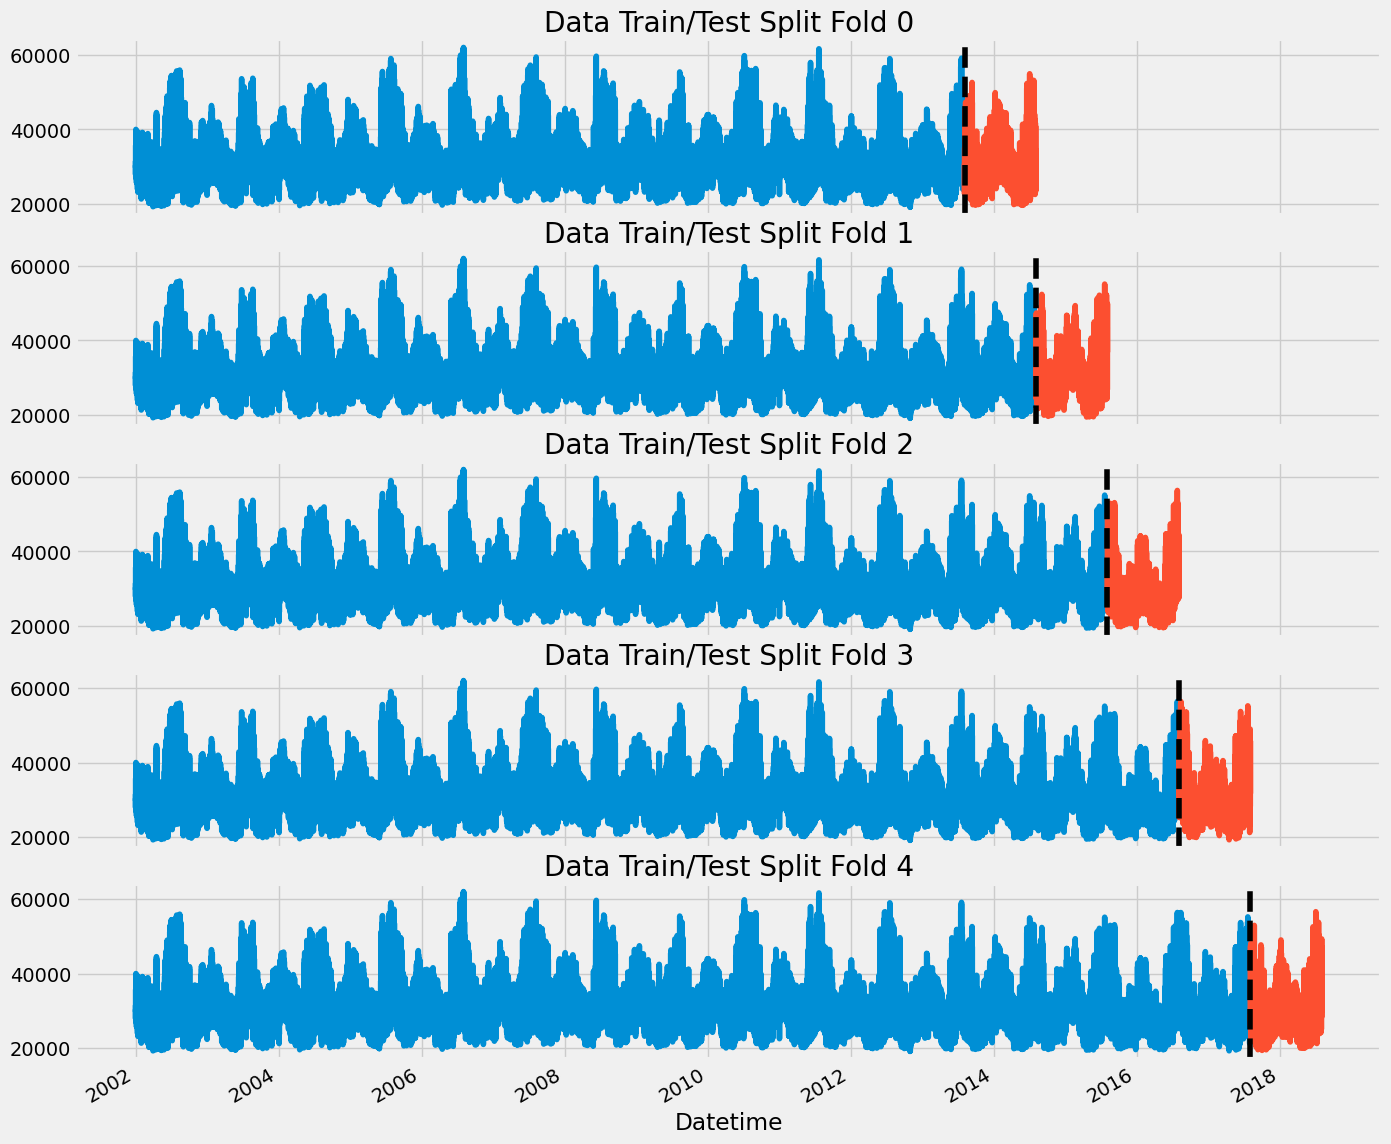

In [136]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

### 2. Forecasting Horizon Explained

- The forecast horizon is the length of time into the future for which forecasts are to be prepared.
- These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).
---

### **Forecasting Horizon in Time Series Analysis**

- The **forecasting horizon** refers to the number of time steps into the future that you aim to predict or forecast in a time series model.
- It defines how far ahead you want to project based on the available data.
- The length of the forecasting horizon has significant implications for model selection, evaluation, and performance.
---
### Key Aspects of the Forecasting Horizon

1. **Definition**:
   - The forecasting horizon is the span of future periods (e.g., hours, days, months, or years) for which predictions are made.
   - For example, in electricity demand forecasting, you might forecast the next 24 hours (1-day horizon) or the next 7 days (1-week horizon).

2. **Short-Term vs. Long-Term Forecasting**:
   - **Short-Term Forecasting**:
       - Predictions made for a short time into the future, such as the next few minutes, hours, or days.
       - These are typically used for operational decisions.
   - **Long-Term Forecasting**:
       - Predictions made for a long time into the future, such as months or years.
       - These forecasts are often used for strategic planning or policy decisions.
   
3. **Single-Step vs. Multi-Step Forecasting**:
   - **Single-Step Forecasting**:
       - Predicts only the next time step (e.g., forecasting the temperature for the next hour).
   - **Multi-Step Forecasting**:
       - Predicts multiple time steps into the future (e.g., predicting temperatures for the next week). This can be done in one of two ways:
         - **Direct Multi-Step Forecasting**: Forecasts each future step independently.
         - **Iterative Multi-Step Forecasting**: Uses the prediction for the next time step as an input to predict further future time steps.
---
### **Importance of Forecasting Horizon**:

- **Impact on Model Complexity**: 
  - Short-term forecasts generally allow models to use recent trends and patterns, while long-term forecasts may require capturing more complex, long-range dependencies and trends in the data.
  
- **Accuracy Degradation**:
  - The accuracy of forecasts generally decreases as the forecasting horizon increases because uncertainty accumulates the further out the forecast is.
  
- **Evaluation Metrics**:
  - Different metrics might be used to evaluate short-term and long-term forecasts (e.g., Mean Squared Error (MSE) or Mean Absolute Percentage Error (MAPE)).
---
### **Examples of Forecasting Horizon**:

1. **Energy Demand Forecasting**: 
   - **Short-Term**: Predicting electricity consumption for the next hour or day (used for grid balancing and operational decisions).
   - **Long-Term**: Forecasting energy demand for the next year (used for capacity planning and infrastructure development).


2. **Weather Forecasting**:
   - **Short-Term**: Predicting tomorrow's temperature or rainfall.
   - **Long-Term**: Predicting seasonal patterns for the upcoming months.


3. **Stock Price Prediction**:
   - **Short-Term**: Predicting stock prices for the next minute or day.
   - **Long-Term**: Predicting stock trends for the next quarter or year.
---
### **Choosing the Forecasting Horizon**:

When selecting the forecasting horizon for a time series problem, you should consider:

- **Business Needs**: What time frame is important for decision-making? Is it critical to know the next hour's sales, or do you need a long-term financial forecast?
- **Data Availability**: Do you have enough historical data to make accurate long-term forecasts?
- **Model Limitations**: Some models are better suited for short-term forecasting (e.g., ARIMA, Exponential Smoothing), while others can capture long-term dependencies (e.g., LSTM, Prophet).


In [137]:
# Create features
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [138]:
df.head(1)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1


### 3. Lag Features
- What was the target (x) days in the past.

In [139]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map) # 364 days / 7 days = 52 (best selection!). But if u choose 365 we 'll get 52.14
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df 

df = add_lags(df)

### Train Using Cross Validation
- Put all together.

In [140]:
tss = TSS(n_splits=5,
          test_size=24*365*1, 
          gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year', 'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, 
                           booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, 
            y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.49608	validation_1-rmse:31956.60163


C:\Users\xps\anaconda3\envs\MLDL\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:46:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12532.64369	validation_1-rmse:11906.14134
[200]	validation_0-rmse:5747.92495	validation_1-rmse:5359.26490
[300]	validation_0-rmse:3872.48134	validation_1-rmse:3900.86965
[400]	validation_0-rmse:3434.23853	validation_1-rmse:3762.33705
[442]	validation_0-rmse:3369.34730	validation_1-rmse:3764.82810
[0]	validation_0-rmse:32672.16678	validation_1-rmse:32138.89241


C:\Users\xps\anaconda3\envs\MLDL\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:46:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12513.65574	validation_1-rmse:12224.93373
[200]	validation_0-rmse:5753.34937	validation_1-rmse:5662.07107
[300]	validation_0-rmse:3902.71304	validation_1-rmse:3933.73076
[400]	validation_0-rmse:3476.90515	validation_1-rmse:3590.55005
[500]	validation_0-rmse:3353.72424	validation_1-rmse:3516.39915
[600]	validation_0-rmse:3297.94766	validation_1-rmse:3481.94003
[700]	validation_0-rmse:3258.48267	validation_1-rmse:3461.37383
[800]	validation_0-rmse:3221.51553	validation_1-rmse:3436.49603
[900]	validation_0-rmse:3190.11480	validation_1-rmse:3428.88699
[999]	validation_0-rmse:3166.16314	validation_1-rmse:3420.31309
[0]	validation_0-rmse:32631.20370	validation_1-rmse:31073.29733


C:\Users\xps\anaconda3\envs\MLDL\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:46:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12499.28425	validation_1-rmse:11136.72805
[200]	validation_0-rmse:5750.81453	validation_1-rmse:4813.21239
[300]	validation_0-rmse:3917.04200	validation_1-rmse:3553.40541
[400]	validation_0-rmse:3494.55924	validation_1-rmse:3495.25153
[410]	validation_0-rmse:3476.66883	validation_1-rmse:3502.18342
[0]	validation_0-rmse:32528.44438	validation_1-rmse:31475.39670


C:\Users\xps\anaconda3\envs\MLDL\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:46:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12462.30026	validation_1-rmse:12019.98579
[200]	validation_0-rmse:5738.32648	validation_1-rmse:5794.44193
[300]	validation_0-rmse:3915.76448	validation_1-rmse:4385.51180
[400]	validation_0-rmse:3499.03653	validation_1-rmse:4172.17589
[500]	validation_0-rmse:3382.83569	validation_1-rmse:4116.88298
[600]	validation_0-rmse:3324.23232	validation_1-rmse:4104.48851
[700]	validation_0-rmse:3281.46398	validation_1-rmse:4088.10832
[800]	validation_0-rmse:3249.57813	validation_1-rmse:4081.68309
[900]	validation_0-rmse:3223.05405	validation_1-rmse:4071.80961
[999]	validation_0-rmse:3198.63557	validation_1-rmse:4048.63496
[0]	validation_0-rmse:32462.05557	validation_1-rmse:31463.90500


C:\Users\xps\anaconda3\envs\MLDL\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:47:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12445.92077	validation_1-rmse:11962.25620
[200]	validation_0-rmse:5752.09311	validation_1-rmse:5610.63120
[300]	validation_0-rmse:3953.21146	validation_1-rmse:4149.60103
[400]	validation_0-rmse:3541.03825	validation_1-rmse:3998.83825
[440]	validation_0-rmse:3481.72497	validation_1-rmse:4001.67488


### Metrics

In [141]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3740.5258
Fold scores:[3760.8277187583353, 3420.313091887879, 3477.9504020604863, 4048.634962892725, 3994.9029963460744]


### 4. Predicting the Future
1. Retraining on all data
2. To Predict the future we need an emtpy dataframe for future date ranges (create a new DataFrame).
3. Run those dates through our feature creation code + lag creation

##### 1. Retraining on all data (Why?)
When using TimeSeriesSplit in XGBoost for time series forecasting, retraining on all the data after each split is done for several key reasons:

1. Time Series Nature:
- Time series data is sequential, meaning that future data points depend on past data points. The patterns, trends, seasonality, and dependencies in time series data can evolve over time.
- To properly forecast future values, it’s essential to use all the available data up to the current point to capture the latest patterns and trends.
- This is different from non-time-series data where relationships might remain relatively stable.

2. Sequential Dependency:
- In time series data, each new data point may provide additional information that wasn’t available before. The model needs to be retrained on all previous data up to the current point to make better predictions on future data.
- For instance, a pattern might not be evident in earlier portions of the time series, but as more data becomes available, it may emerge.
- By retraining on the entire data, XGBoost can capture these evolving relationships.
  
3. Overfitting to Historical Patterns:
- If you only train on a small window of past data, the model might overfit to recent trends and not generalize well to future data points.
- By retraining on the full dataset up to each split, you prevent the model from focusing too narrowly on the most recent data, allowing it to generalize better.
  
4. Incorporating All Information:
- By retraining on all the data, the model uses all available historical information up to the current time.
- This ensures the model captures long-term trends, seasonality, and autocorrelations in the data that are important for making accurate forecasts.
- In time series, the further back you go, the more information you have. Even old data can sometimes provide valuable context or indicate cyclic behavior, which helps the model forecast future points more accurately.
  
5. Avoiding Data Leakage:
- TimeSeriesSplit is designed to prevent data leakage, which occurs when information from future data points is used to predict past data.
- Each fold in TimeSeriesSplit makes sure that training is only done on past data, ensuring that future data is not available during training.
- By retraining on all the data after each split, you ensure that no future information "leaks" into the training set.

In [142]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, 
        y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32403.88991


C:\Users\xps\anaconda3\envs\MLDL\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:47:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12426.77634
[200]	validation_0-rmse:5753.18185
[300]	validation_0-rmse:3970.09750
[400]	validation_0-rmse:3569.04143
[499]	validation_0-rmse:3456.41787


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

##### 2. Create a new DataFrame

In [143]:
# Check the maximum value in the Dataset to make the prediction for the future by using:
# Our training dataset goes up untill "2018-08-03" and make it as the first date in the new DataFrame
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [144]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')

future_df = pd.DataFrame(index=future) # new DataFrame
future_df['isFuture'] = True # Add a new column "isFuture" to save the future favlues 
df['isFuture'] = False # do the same for the df
df_and_future = pd.concat([df, future_df]) # Concatenate them to add the new dates to the time series

df_and_future = create_features(df_and_future) # Add a features to the new Time Series
df_and_future = add_lags(df_and_future) # Add a lags to it too

In [145]:
# Extract out just the future data (select the column where we will save the future data (isFuture)) by:
future_w_features = df_and_future.query('isFuture').copy()

##### 3. Predict the future

In [146]:
# Predict the future: future with features (future_w_features)
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

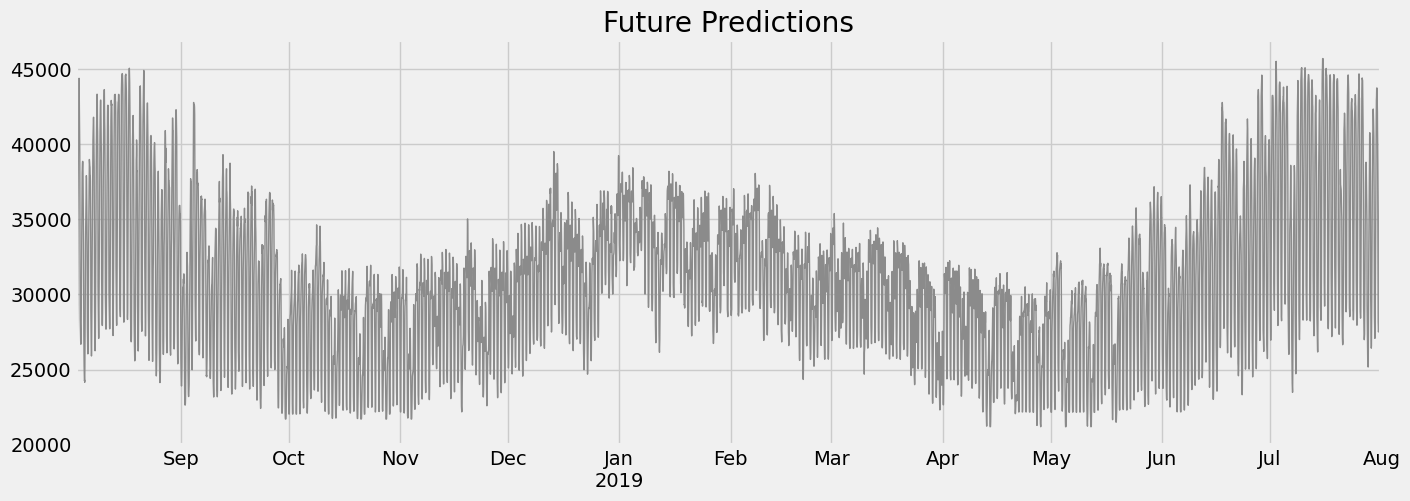

In [147]:
# Visualize it
future_w_features['pred'].plot(figsize=(15, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

### Prediction by hour

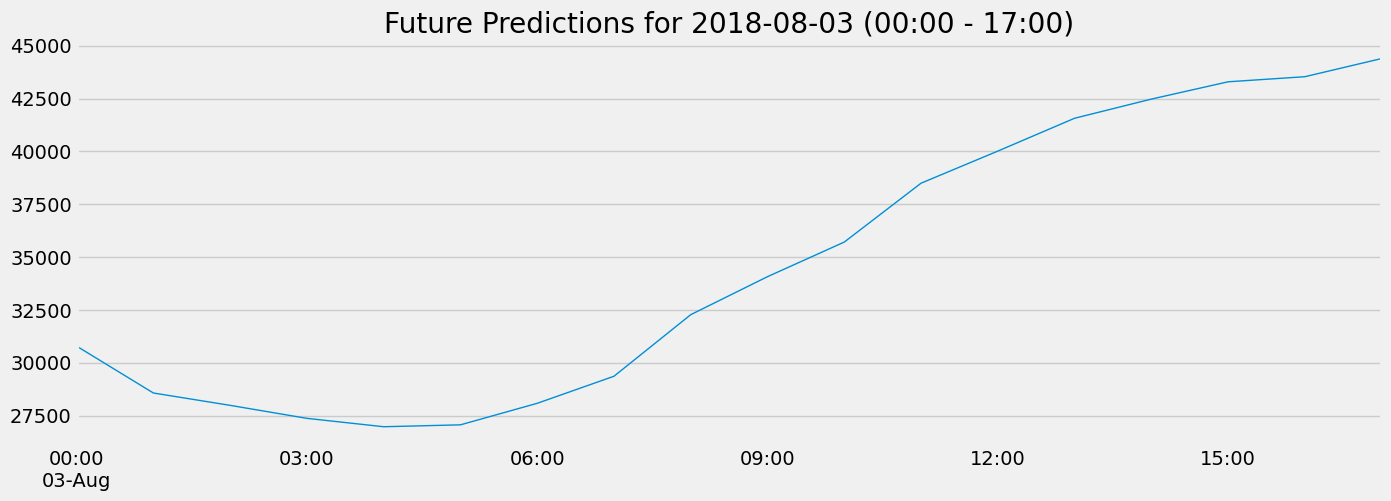

In [148]:
# Create future dataframe for the specific date and time range (2018-08-03 from 00:00 to 17:00)
future = pd.date_range('2018-08-03 00:00', '2018-08-03 17:00', freq='1h')

# Create a DataFrame for future predictions
future_df = pd.DataFrame(index=future)  # new DataFrame
future_df['isFuture'] = True  # Add a new column "isFuture" to identify future data
df['isFuture'] = False  # Mark existing data as not future

# Concatenate existing and future data
df_and_future = pd.concat([df, future_df])  # Concatenate to add the new dates to the time series

# Add features and lags to the new combined DataFrame
df_and_future = create_features(df_and_future)  # Add features to the new Time Series
df_and_future = add_lags(df_and_future)  # Add lags for modeling

# Extract only the future data (those marked as "isFuture")
future_w_features = df_and_future.query('isFuture').copy()

# Predict the future data (for the specified date and time)
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

# Visualize the prediction
future_w_features['pred'].plot(figsize=(15, 5),
                               color=color_pal[0],
                               ms=1,
                               lw=1,
                               title='Future Predictions for 2018-08-03 (00:00 - 17:00)')
plt.show()

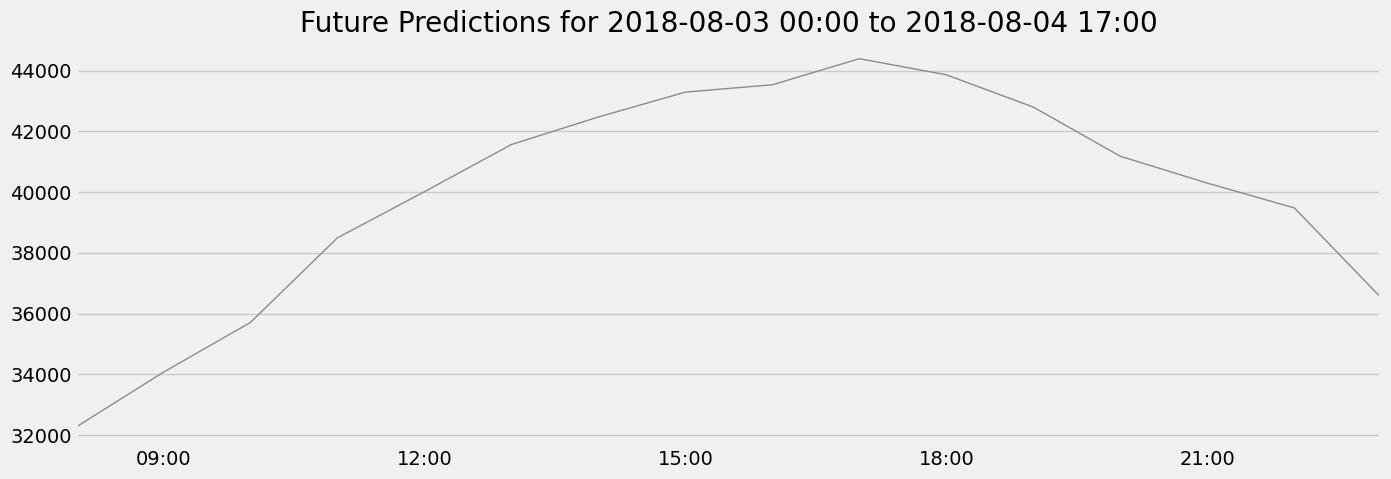

In [149]:
# Create future dataframe for the specific date and time range (2018-08-03 from 00:00 to 2018-08-04 17:00)
future = pd.date_range('2018-08-03 08:00', '2018-08-03 23:59', freq='1h')

# Create a DataFrame for future predictions
future_df = pd.DataFrame(index=future)  # new DataFrame
future_df['isFuture'] = True  # Add a new column "isFuture" to identify future data
df['isFuture'] = False  # Mark existing data as not future

# Concatenate existing and future data
df_and_future = pd.concat([df, future_df])  # Concatenate to add the new dates to the time series

# Add features and lags to the new combined DataFrame
df_and_future = create_features(df_and_future)  # Add features to the new Time Series
df_and_future = add_lags(df_and_future)  # Add lags for modeling

# Extract only the future data (those marked as "isFuture")
future_w_features = df_and_future.query('isFuture').copy()

# Predict the future data (for the specified date and time)
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

# Visualize the prediction
future_w_features['pred'].plot(figsize=(15, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions for 2018-08-03 00:00 to 2018-08-04 17:00')
plt.show()


### Saving Model For later

In [150]:
# Save model
reg.save_model('model.json')
# !dir

<Axes: title={'center': 'Future Predictions'}>

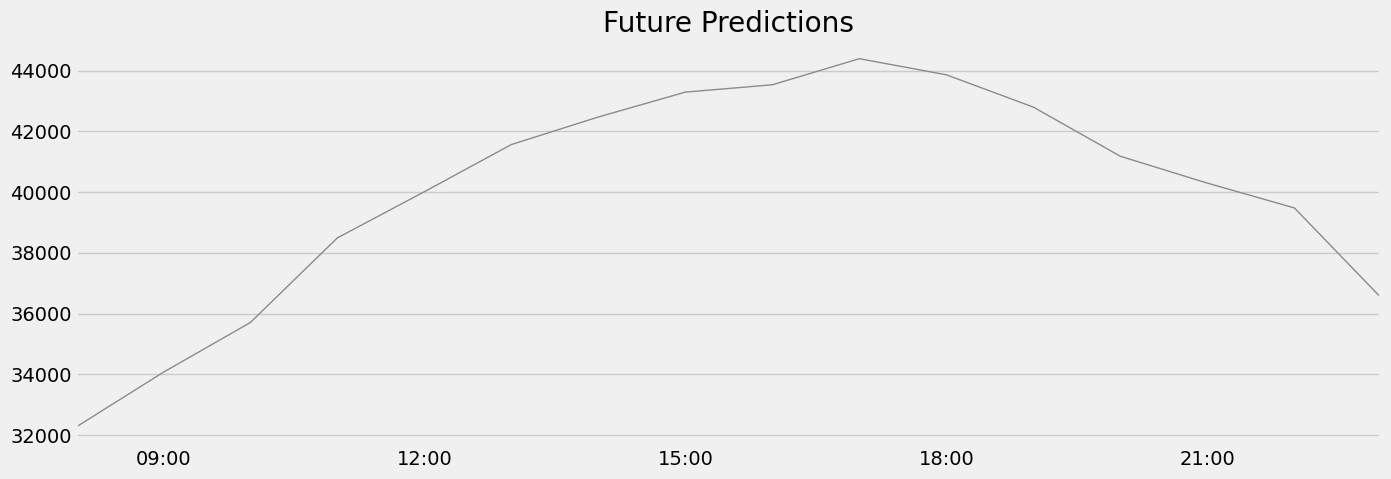

In [151]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(15, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')